In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import os
import datetime
from numpy import concatenate
from matplotlib import pyplot
from pandas import DataFrame, concat
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from keras.models import Sequential
from keras.layers import Dense, LSTM, Conv1D, Bidirectional, Flatten, GRU
import IPython
import IPython.display
import matplotlib as mpl
import seaborn as sns
import tensorflow as tf
from helper import *
from pandas import read_csv
from math import sqrt

physical_devices = tf.config.experimental.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

mpl.rcParams['axes.grid'] = False

In [2]:
### LOAD DATASET ###

df = read_csv('df.csv')
dataset = df.set_index('date')
df

date        p5  rain
0    2015-04-10  1.041892  12.4
1    2015-04-21  0.186168  34.0
2    2015-05-02 -2.374851  31.6
3    2015-05-13  0.548328  62.4
4    2015-05-24 -0.684310   8.2
..          ...       ...   ...
156  2019-12-21 -1.270302  20.8
157  2020-01-01  2.232585  26.8
158  2020-01-12  0.175435   1.8
159  2020-01-23 -0.253113  61.0
160  2020-02-03  0.346710  39.6

[161 rows x 3 columns]

<AxesSubplot:>

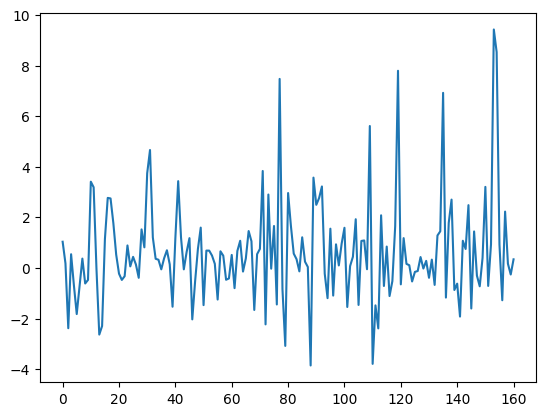

In [3]:
# plot displacement
df['p5'].plot()

<AxesSubplot:>

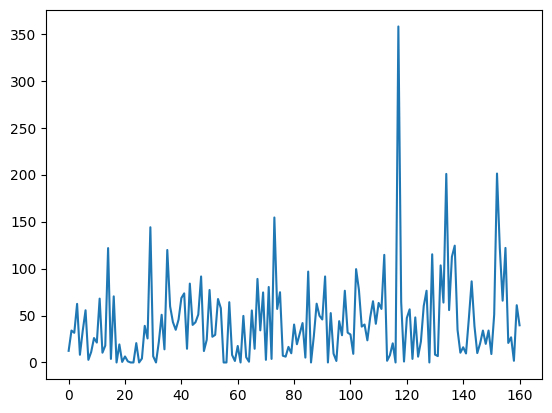

In [4]:
# plot rain
df['rain'].plot()

In [5]:
# statistics of the dataset
df.describe().transpose()

count       mean        std       min       25%        50%        75%  \
p5    161.0   0.634245   2.032216 -3.847115 -0.467202   0.381206   1.214105   
rain  161.0  43.162733  46.266452  0.000000  9.400000  34.000000  62.400000   

             max  
p5      9.427837  
rain  357.800000

In [6]:
# DEFINE TRAINING LENGHT (the remaining will be test)

#training hours
hours_train=100

# total number of variables
n_features = 2

-------------------------------------------------------------------------------------
MLP
Filters:  16
Learning rate:  0.01
Batch size:  9
Look back:  3
(158, 8)
(97, 6) 97 (97,)
(97, 3, 2) (97,) (61, 3, 2) (61,)


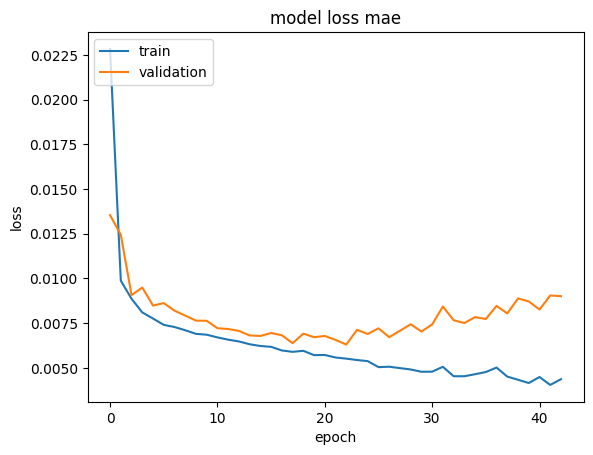

Test MAE: 1.713
Test RMSE: 2.527
Test MAPE: 2.810
Test R2: -0.065


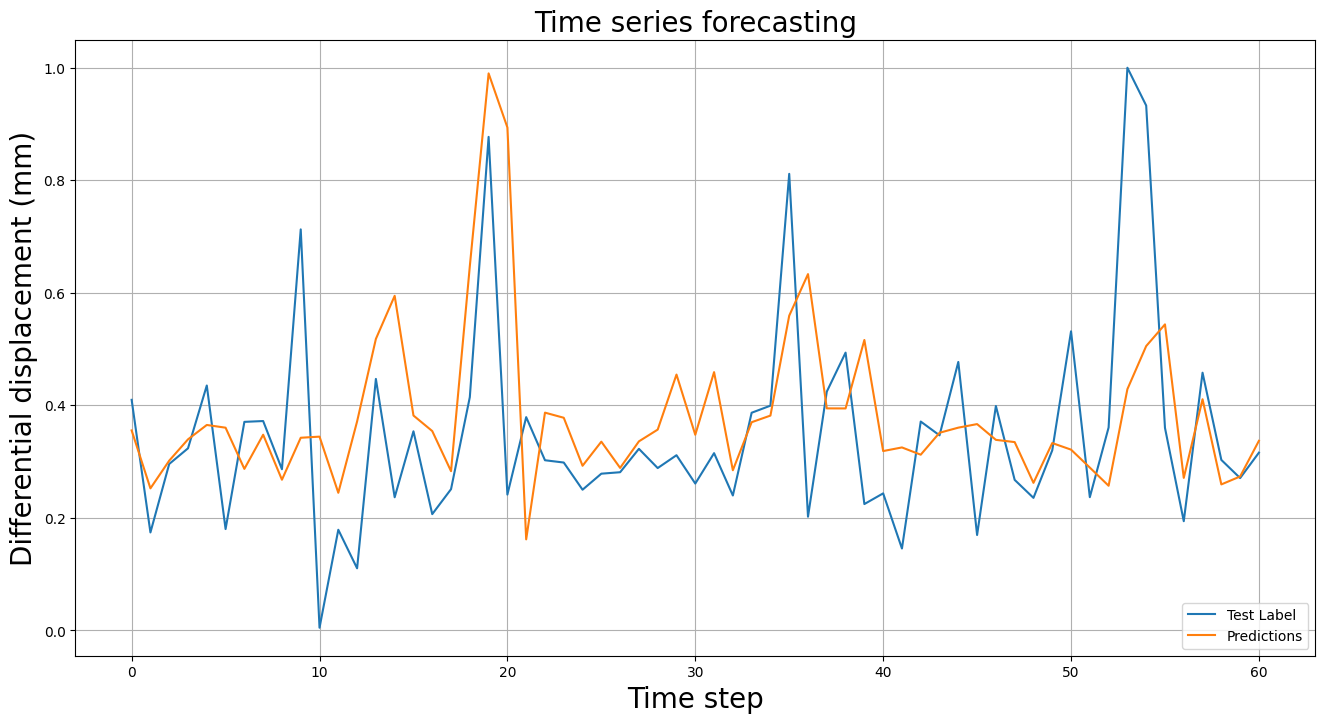

-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
MLP
Filters:  16
Learning rate:  0.01
Batch size:  9
Look back:  5
(156, 12)
(95, 10) 95 (95,)
(95, 5, 2) (95,) (61, 5, 2) (61,)


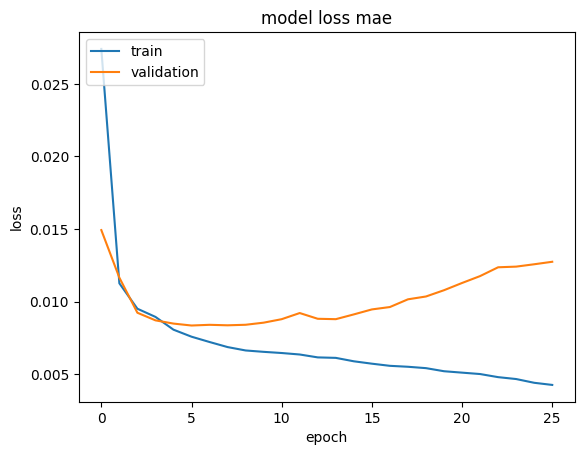

Test MAE: 1.870
Test RMSE: 2.665
Test MAPE: 2.114
Test R2: -0.184


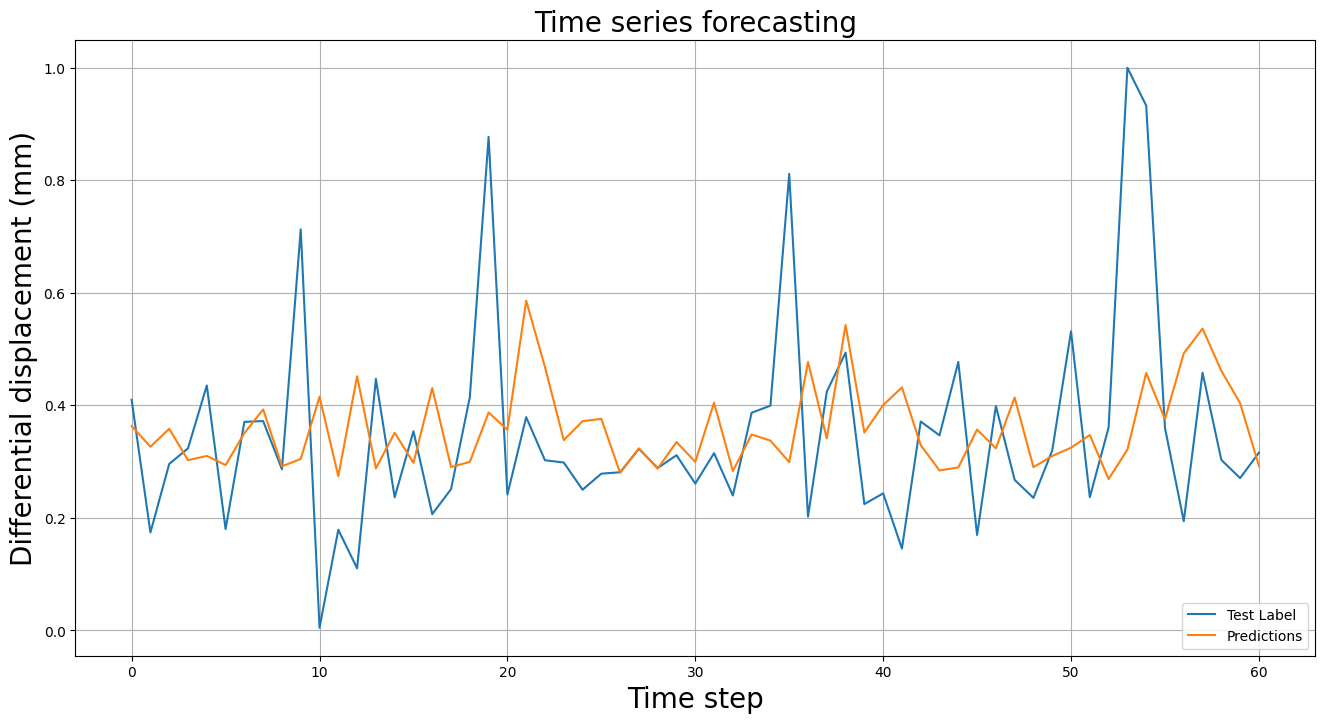

-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
MLP
Filters:  16
Learning rate:  0.01
Batch size:  9
Look back:  7
(154, 16)
(93, 14) 93 (93,)
(93, 7, 2) (93,) (61, 7, 2) (61,)


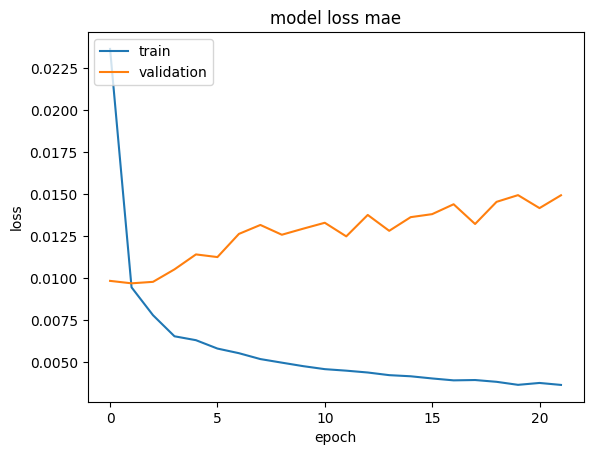

Test MAE: 1.709
Test RMSE: 2.380
Test MAPE: 2.038
Test R2: 0.056


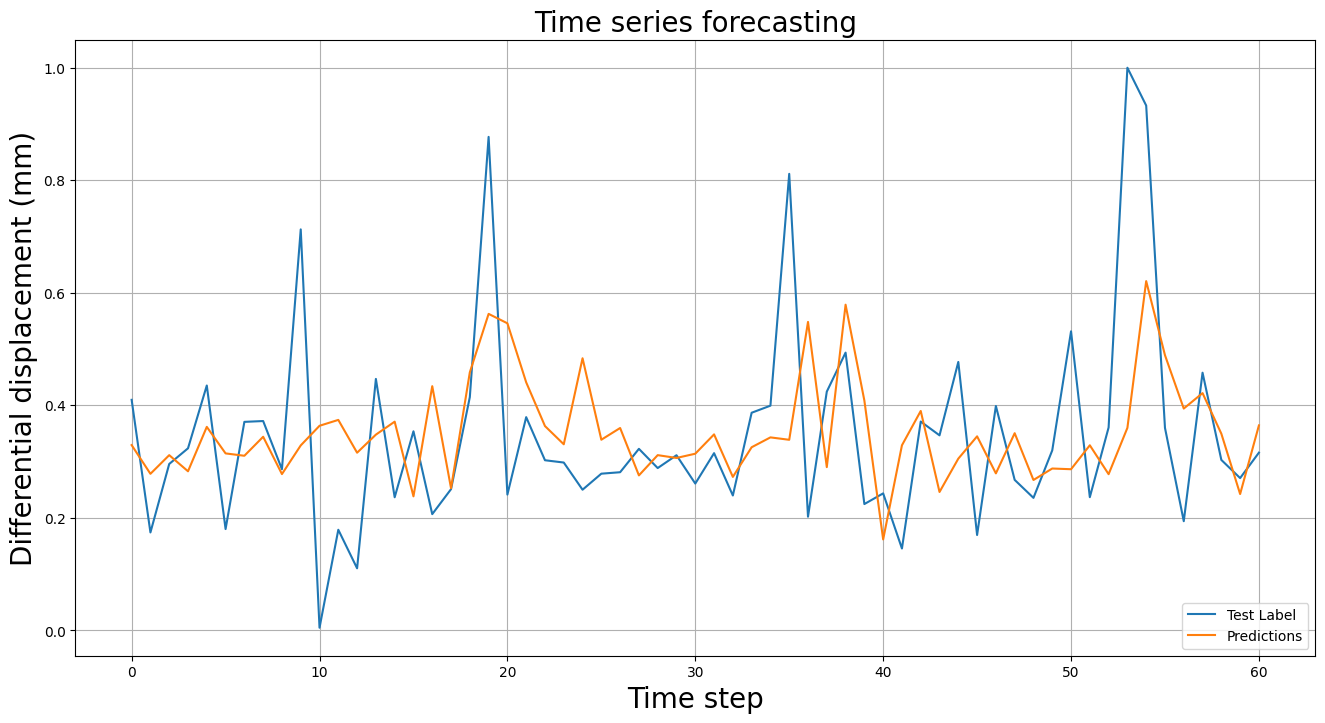

-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
MLP
Filters:  16
Learning rate:  0.01
Batch size:  9
Look back:  9
(152, 20)
(91, 18) 91 (91,)
(91, 9, 2) (91,) (61, 9, 2) (61,)


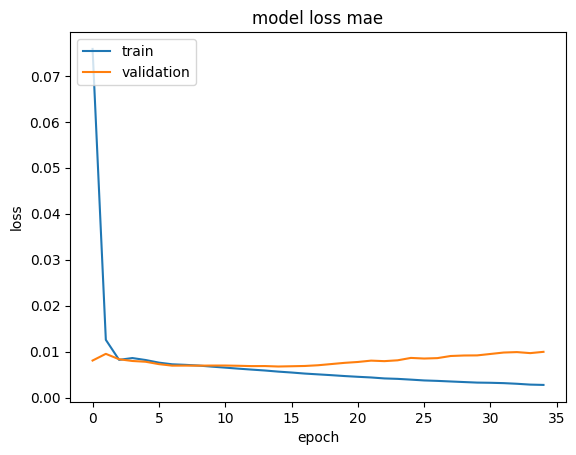

Test MAE: 1.599
Test RMSE: 2.332
Test MAPE: 2.194
Test R2: 0.093


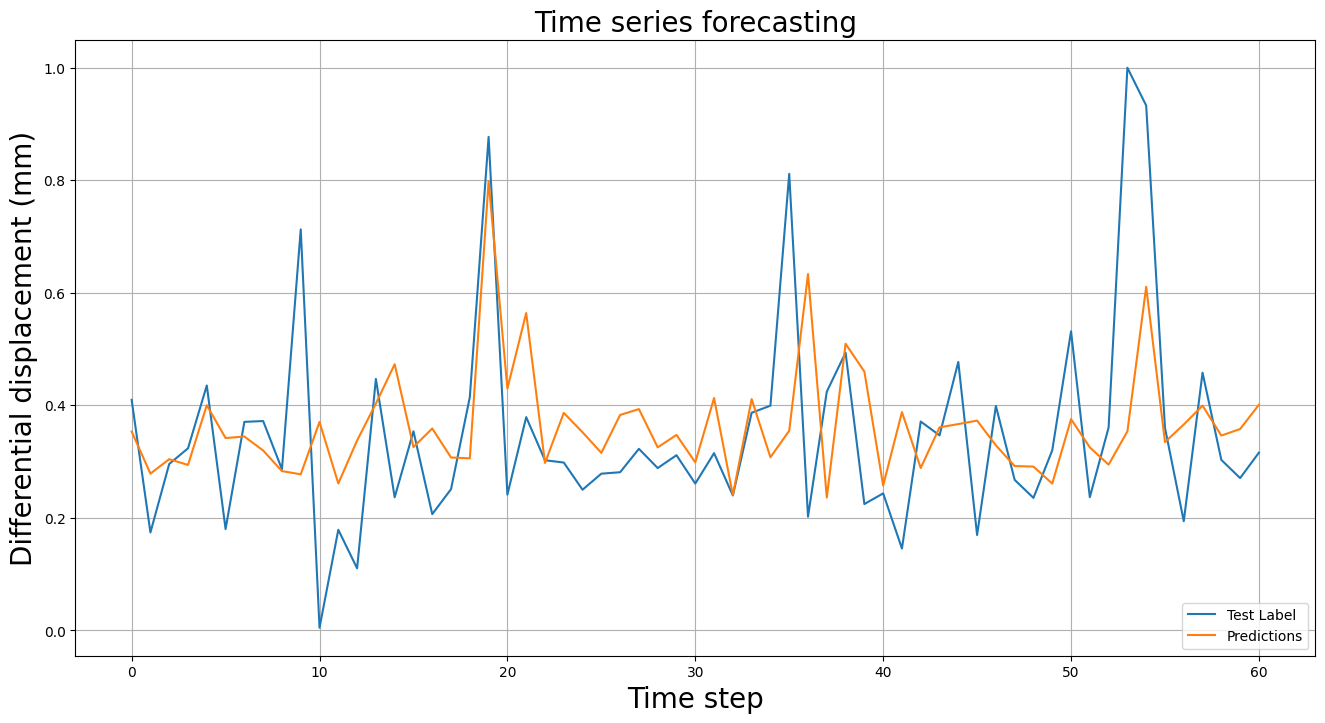

-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
MLP
Filters:  16
Learning rate:  0.01
Batch size:  9
Look back:  12
(149, 26)
(88, 24) 88 (88,)
(88, 12, 2) (88,) (61, 12, 2) (61,)


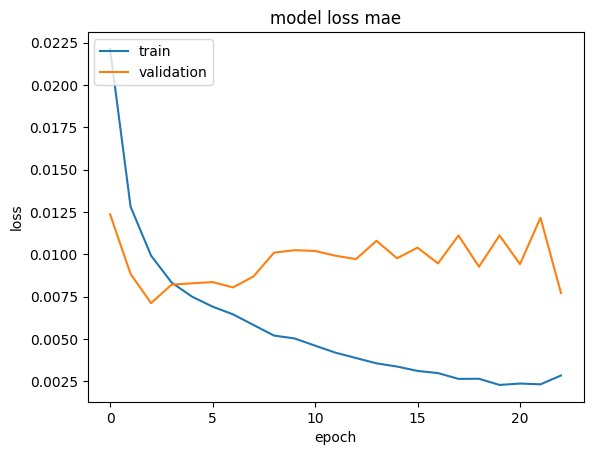

Test MAE: 1.806
Test RMSE: 2.649
Test MAPE: 1.896
Test R2: -0.170


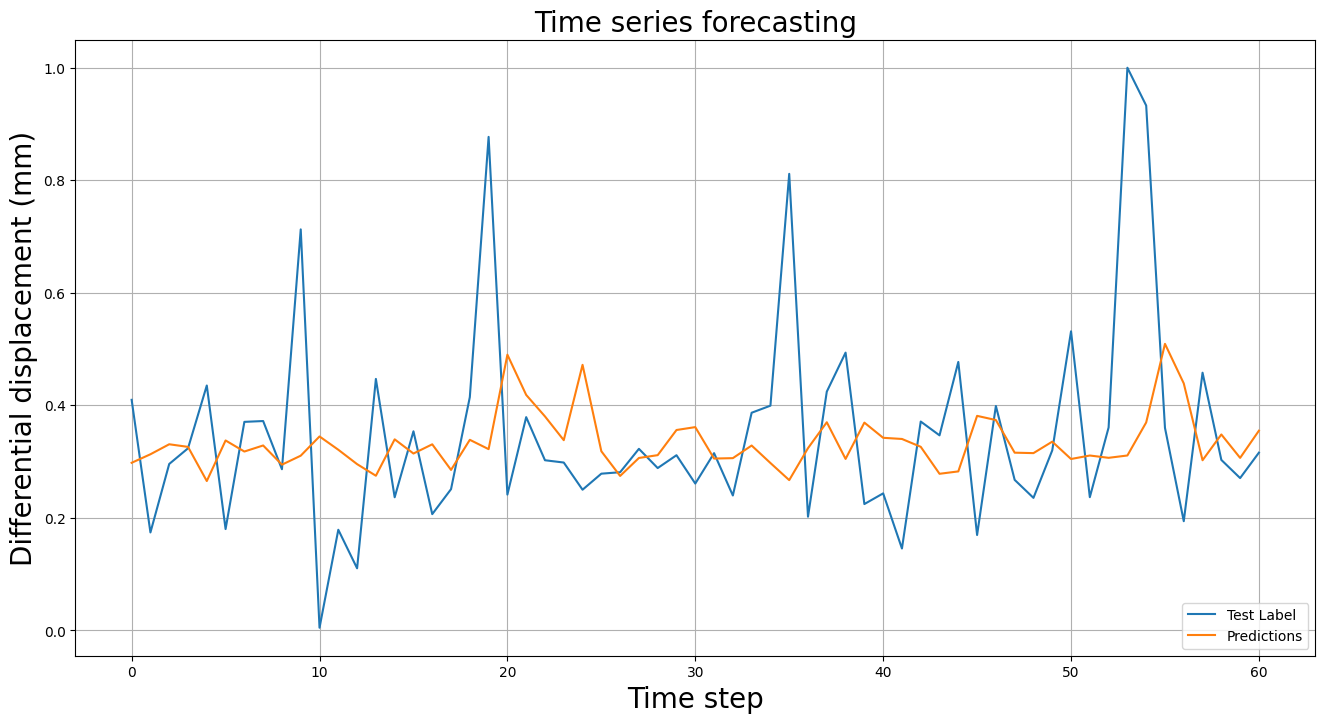

-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
MLP
Filters:  16
Learning rate:  0.01
Batch size:  18
Look back:  3
(158, 8)
(97, 6) 97 (97,)
(97, 3, 2) (97,) (61, 3, 2) (61,)



KeyboardInterrupt



In [7]:
### MLP ###


dic = {}

# number of filters/nodes
filters = [16, 32, 64, 96, 128, 256]
# learning rates
lr = [10e-3, 5e-3, 10e-4, 5e-4, 10e-5, 5e-5]
# epochs
epochs = 1000
# batch sizes
batch_size = [9, 18, 36, 72, 144]
# how many time steps back do we want the model to see
look_backs = [3, 5, 7, 9, 12]

# Hyperparameters
dic["batch_size"] = []
dic["learning_rate"] = []
dic["filters"] = []
dic["look_backs"] = []

# test_scores
dic["MAE"] = []
dic["RMSE"] = []
dic["MAPE"] = []
dic["R2"] = []

for fil in filters:
    for learning_rate in lr:
        for batch in batch_size:
            for look in look_backs:
                print('-------------------------------------------------------------------------------------')
                print('MLP')
                print('Filters: ', fil)
                print('Learning rate: ', learning_rate)
                print('Batch size: ', batch)
                print('Look back: ', look)
                # load dataset
                values = dataset.values
                # ensure all data is float
                values = values.astype('float32')
                # normalize features
                scaler = MinMaxScaler(feature_range=(0, 1))
                scaled = scaler.fit_transform(values)
                # specify the number of lag hours
                n_hours = look
                # frame as supervised learning
                reframed = series_to_supervised(scaled, n_hours, 1)
                print(reframed.shape)

                # split into train and test sets
                values = reframed.values
                n_train_hours = hours_train - look
                train = values[:n_train_hours, :]
                test = values[n_train_hours:, :]
                # split into input and outputs
                n_obs = n_hours * n_features
                train_X, train_y = train[:, :n_obs], train[:, -n_features]
                test_X, test_y = test[:, :n_obs], test[:, -n_features]
                print(train_X.shape, len(train_X), train_y.shape)

                # reshape input to be 3D [samples, timesteps, features]
                train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
                test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
                print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

                n = - n_features + 1


                def multi_dense_net(filters, lr):
                    model = Sequential()
                    model.add(Flatten(input_shape=(train_X.shape[1], train_X.shape[2])))
                    model.add(Dense(filters, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
                    model.add(Dense(filters, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
                    model.add(Dense(1))
                    model.compile(loss=tf.losses.Huber(),
                                  optimizer=tf.optimizers.Adam(learning_rate=lr),
                                  metrics=[tf.metrics.MeanAbsoluteError(), tf.metrics.MeanSquaredError()])
#                     model.summary()
                    return model


                # load the model
                model = multi_dense_net(filters=fil, lr=learning_rate)
                # Save the models only when validation loss decrease
                early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',  # what is the metric to measure
                                                              patience=20,
                                                              # how many epochs to continue running the model after seeing an increase in val_loss
                                                              restore_best_weights=True)  # update the model weights
                model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                    f'models/MLP/weights/filters_{fil}_batch_size_{batch}_lr_{learning_rate}_look_back_{look}.hdf5',
                    monitor='val_loss', mode='min', verbose=0,
                    save_best_only=True, save_weights_only=True)
                # fit network
                history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch, validation_split=0.2, verbose=0,
                                    shuffle=False, callbacks=[model_checkpoint, early_stop])

                plt.plot(history.history['loss'])
                plt.plot(history.history['val_loss'])
                plt.title('model loss mae')
                plt.ylabel('loss')
                plt.xlabel('epoch')
                plt.legend(['train', 'validation'], loc='upper left')
                # save plots
                plt.savefig(f"models/MLP/plots/filters_{fil}_batch_size_{batch}_lr_{learning_rate}_look_back_{look}.png")
                plt.show()

                # load model to evaluate the test data
                multi_dense_model = multi_dense_net(filters=fil, lr=learning_rate)
                # load the last saved weight from the training
                multi_dense_model.load_weights(
                    f"models/MLP/weights/filters_{fil}_batch_size_{batch}_lr_{learning_rate}_look_back_{look}.hdf5")

                # Evaluate the model
                yhat = multi_dense_model.predict(test_X)
                test_X_res = test_X.reshape((test_X.shape[0], n_hours * n_features))
                # invert scaling for forecast
                inv_yhat = concatenate((yhat, test_X_res[:, n:]), axis=1)
                inv_yhat = scaler.inverse_transform(inv_yhat)
                inv_yhat = inv_yhat[:, 0]
                # invert scaling for actual
                test_y = test_y.reshape((len(test_y), 1))
                inv_y = concatenate((test_y, test_X_res[:, n:]), axis=1)
                inv_y = scaler.inverse_transform(inv_y)
                inv_y = inv_y[:, 0]

                # calculate MAE
                mae = mean_absolute_error(inv_y, inv_yhat)
                print('Test MAE: %.3f' % mae)
                # calculate RMSE
                rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
                print('Test RMSE: %.3f' % rmse)
                # calculate MAPE
                mape = mean_absolute_percentage_error(inv_y, inv_yhat)
                print('Test MAPE: %.3f' % mape)
                # calculate R2
                r2 = r2_score(inv_y, inv_yhat)
                print('Test R2: %.3f' % r2)

                plt.figure(figsize=(16, 8))
                plt.title('Time series forecasting', size=20)
                # plt.ylim([0,1.3])
                plt.plot(pd.DataFrame(test_y), label='Test Label')
                plt.plot(pd.DataFrame(yhat), label='Predictions')
                plt.legend(loc='lower right', markerscale=1)
                plt.xlabel('Time step', size=20)
                plt.ylabel('Differential displacement (mm)', size=20)
                plt.grid(True)
                plt.savefig(f"models/MLP/preds/filters_{fil}_batch_size_{batch}_lr_{learning_rate}_look_back_{look}.png",
                            facecolor='white', edgecolor='none', bbox_inches='tight')
                plt.show()

                # save results on the dictionary
                dic["batch_size"].append(batch)
                dic["learning_rate"].append(learning_rate)
                dic["filters"].append(fil)
                dic["look_backs"].append(look)
                dic["MAE"].append(mae)
                dic["RMSE"].append(rmse)
                dic["MAPE"].append(mape)
                dic["R2"].append(r2)

                # Convert results to a dataframe
                results = pd.DataFrame(dic)
                # Export as csv
                results.to_csv(f'models/MLP/results/multi_dense_results.csv', index=False)
                print('-------------------------------------------------------------------------------------')

print('MLP finished!')

-------------------------------------------------------------------------------------
LSTM
Filters:  16
Learning rate:  0.01
Batch size:  9
Look back:  3
(158, 8)
(97, 6) 97 (97,)
(97, 3, 2) (97,) (61, 3, 2) (61,)
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 16)                1216      
                                                                 
 dense_51 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,233
Trainable params: 1,233
Non-trainable params: 0
_________________________________________________________________


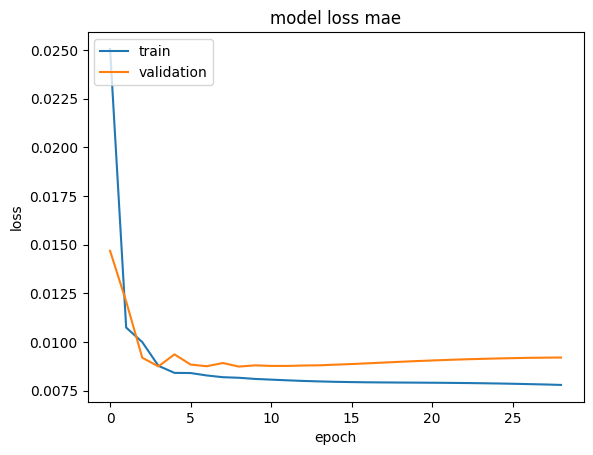

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 16)                1216      
                                                                 
 dense_52 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,233
Trainable params: 1,233
Non-trainable params: 0
_________________________________________________________________
Test MAE: 1.557
Test RMSE: 2.319
Test MAPE: 2.191
Test R2: 0.103


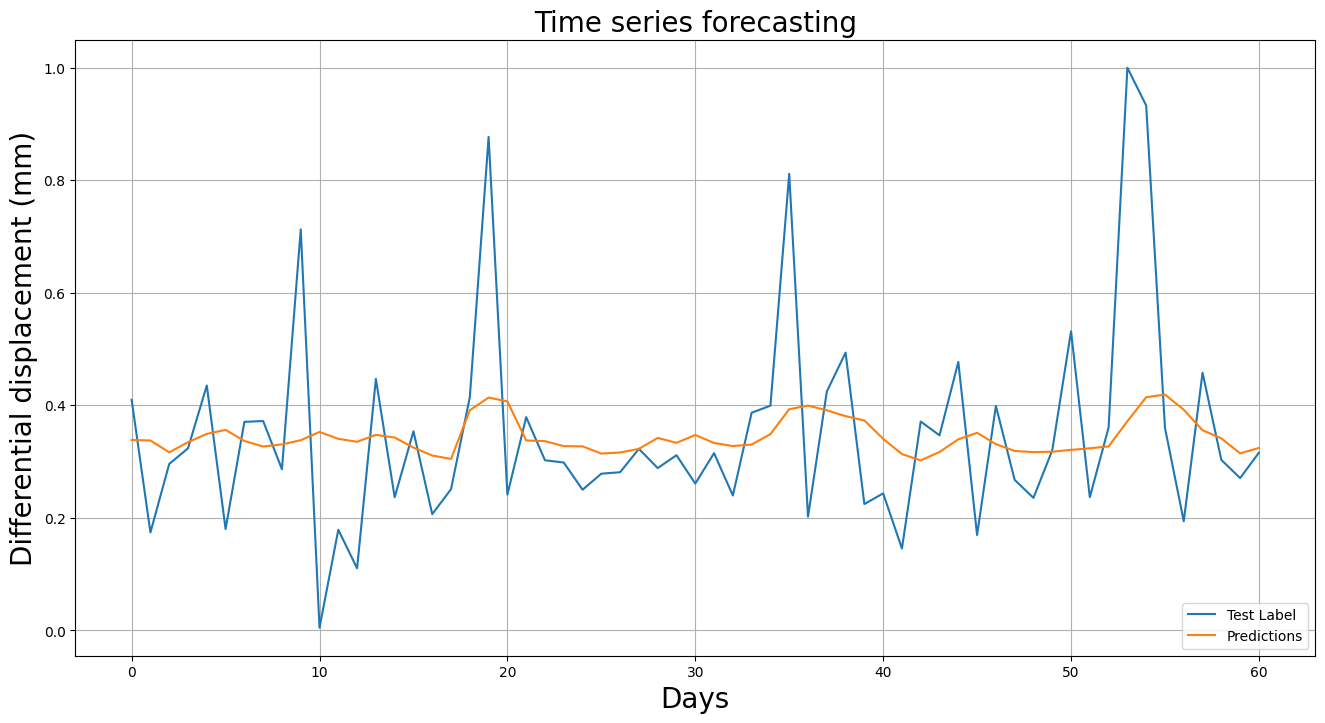

-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
LSTM
Filters:  16
Learning rate:  0.01
Batch size:  9
Look back:  5
(156, 12)
(95, 10) 95 (95,)
(95, 5, 2) (95,) (61, 5, 2) (61,)
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 16)                1216      
                                                                 
 dense_53 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,233
Trainable params: 1,233
Non-trainable params: 0
_________________________________________________________________


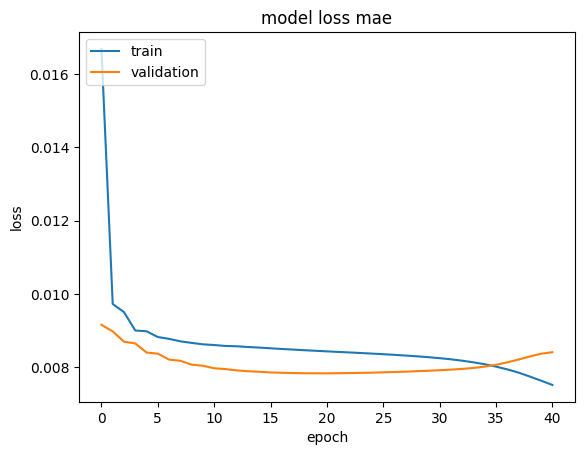

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 16)                1216      
                                                                 
 dense_54 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,233
Trainable params: 1,233
Non-trainable params: 0
_________________________________________________________________
Test MAE: 1.523
Test RMSE: 2.334
Test MAPE: 2.267
Test R2: 0.092


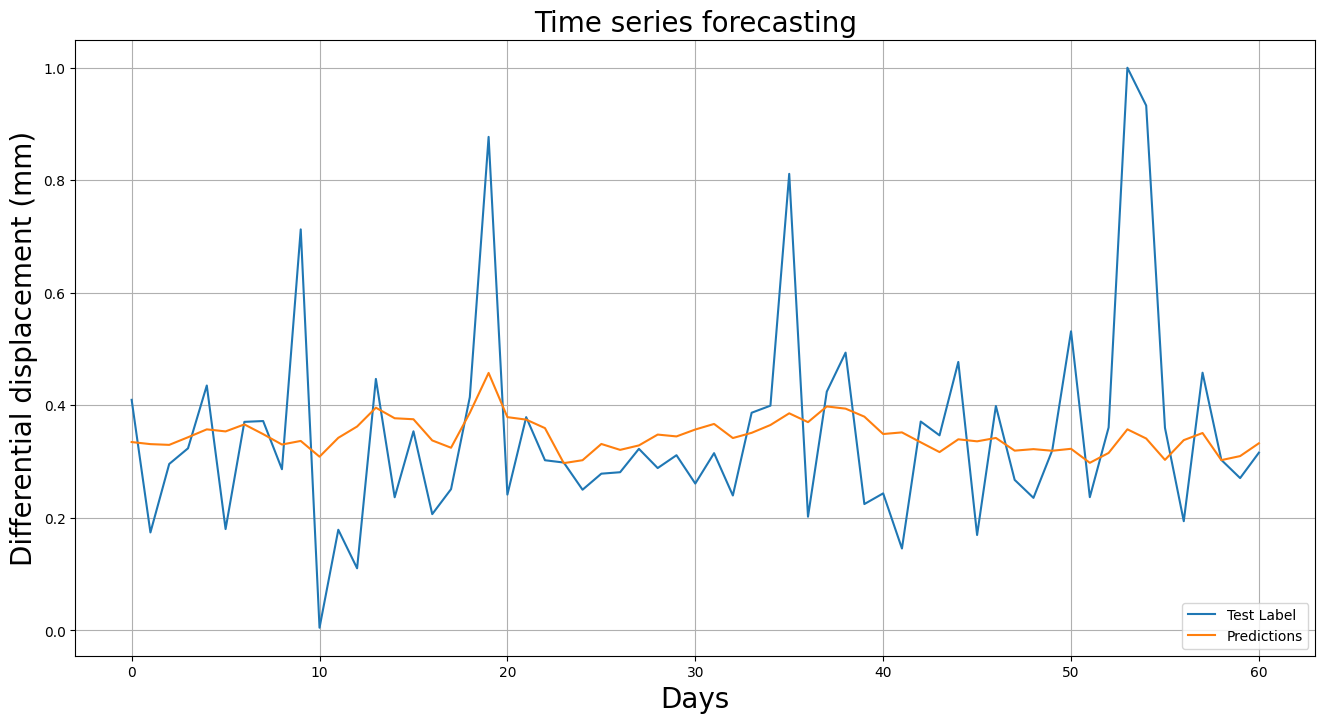

-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
LSTM
Filters:  16
Learning rate:  0.01
Batch size:  9
Look back:  7
(154, 16)
(93, 14) 93 (93,)
(93, 7, 2) (93,) (61, 7, 2) (61,)
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 16)                1216      
                                                                 
 dense_55 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,233
Trainable params: 1,233
Non-trainable params: 0
_________________________________________________________________


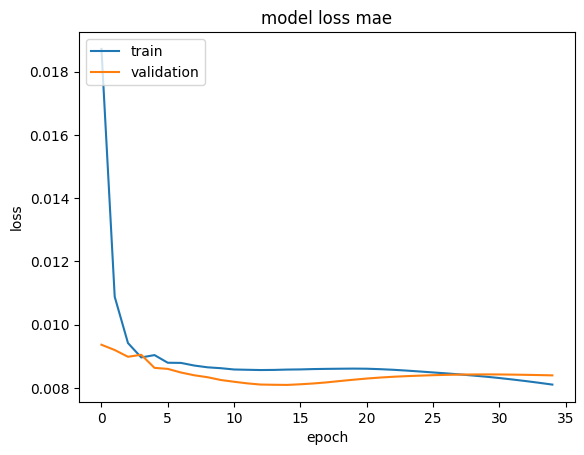

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 16)                1216      
                                                                 
 dense_56 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,233
Trainable params: 1,233
Non-trainable params: 0
_________________________________________________________________
Test MAE: 1.524
Test RMSE: 2.350
Test MAPE: 2.096
Test R2: 0.079


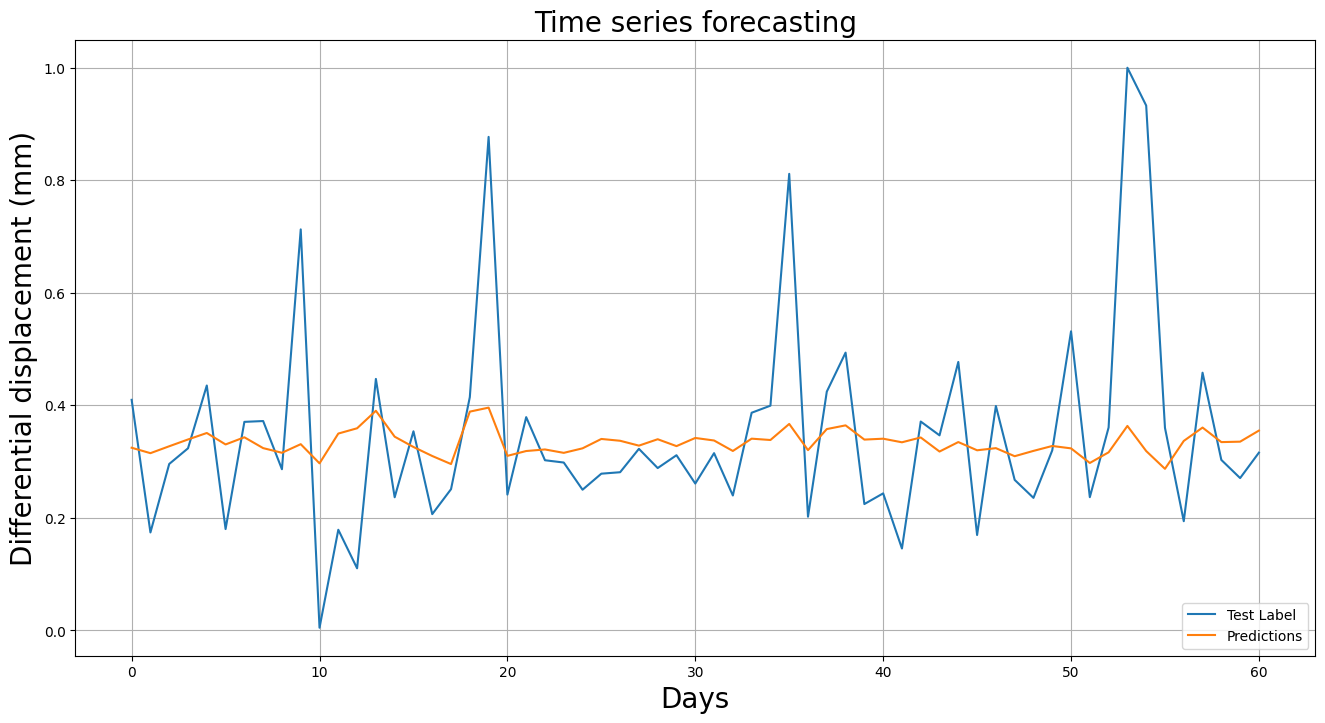

-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
LSTM
Filters:  16
Learning rate:  0.01
Batch size:  9
Look back:  9
(152, 20)
(91, 18) 91 (91,)
(91, 9, 2) (91,) (61, 9, 2) (61,)
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 16)                1216      
                                                                 
 dense_57 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,233
Trainable params: 1,233
Non-trainable params: 0
_________________________________________________________________


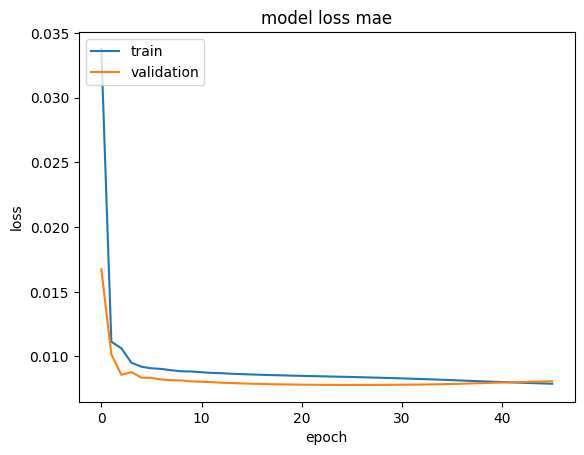

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 16)                1216      
                                                                 
 dense_58 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,233
Trainable params: 1,233
Non-trainable params: 0
_________________________________________________________________
Test MAE: 1.550
Test RMSE: 2.336
Test MAPE: 2.291
Test R2: 0.090


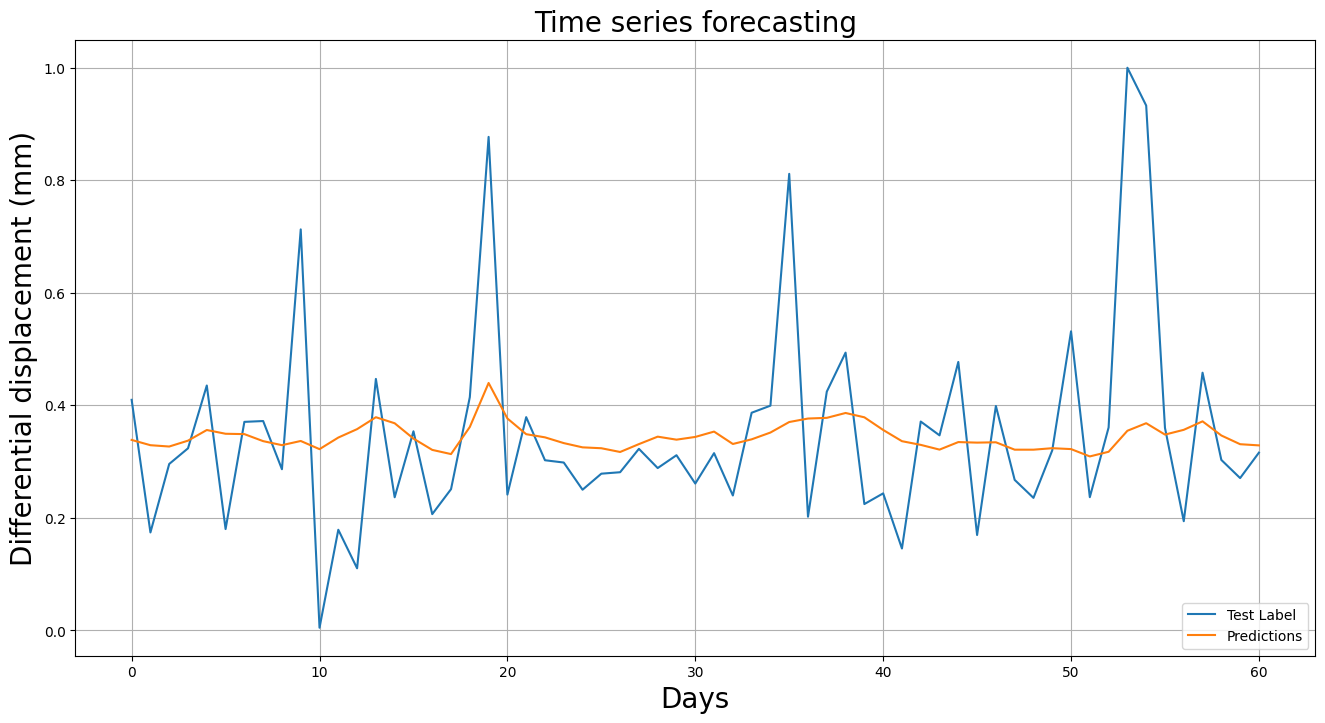

-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
LSTM
Filters:  16
Learning rate:  0.01
Batch size:  9
Look back:  12
(149, 26)
(88, 24) 88 (88,)
(88, 12, 2) (88,) (61, 12, 2) (61,)
Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 16)                1216      
                                                                 
 dense_59 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,233
Trainable params: 1,233
Non-trainable params: 0
_________________________________________________________________


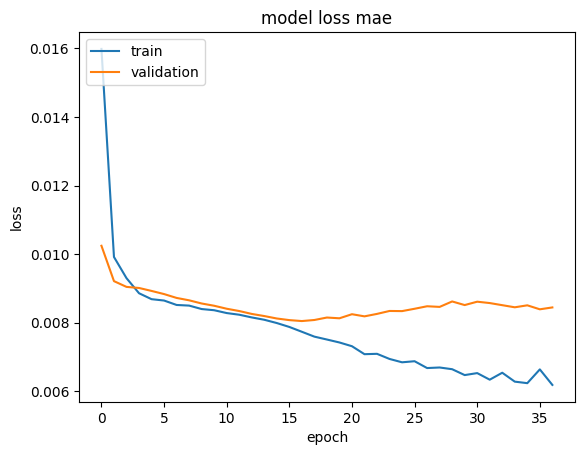

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 16)                1216      
                                                                 
 dense_60 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,233
Trainable params: 1,233
Non-trainable params: 0
_________________________________________________________________
Test MAE: 1.501
Test RMSE: 2.297
Test MAPE: 1.643
Test R2: 0.120


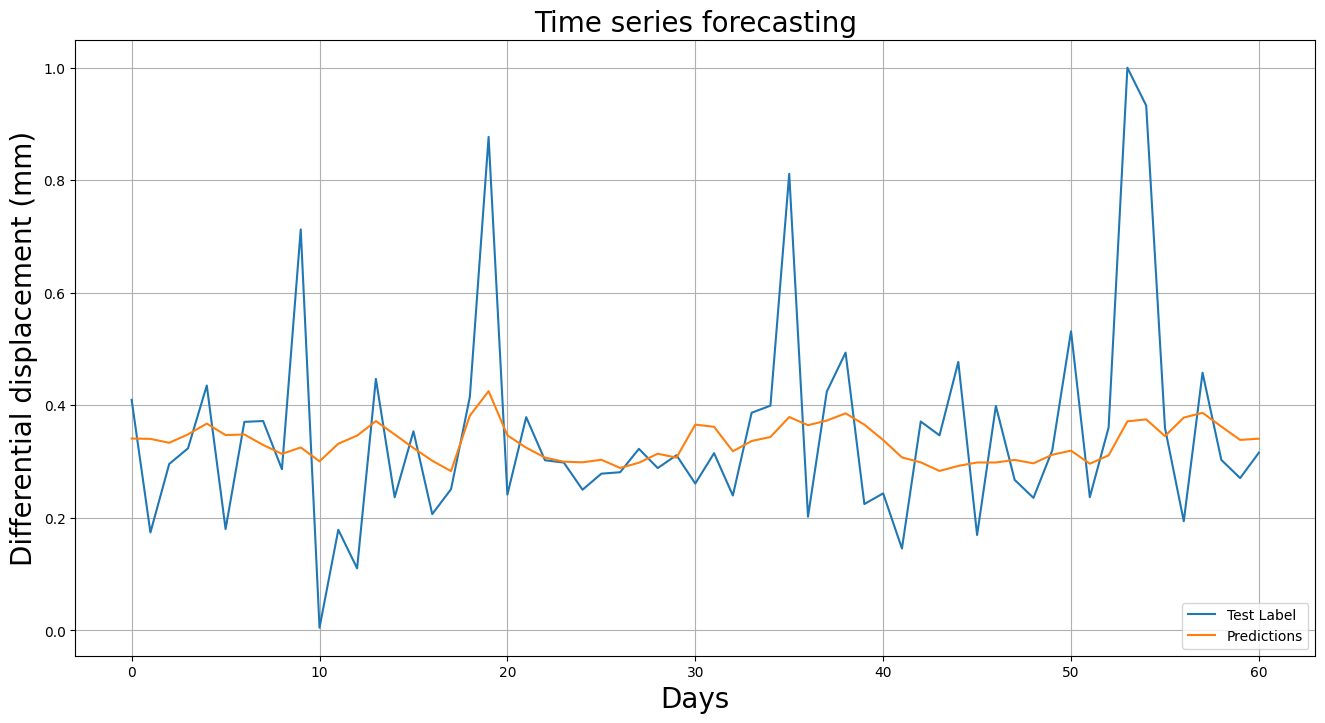

-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
LSTM
Filters:  16
Learning rate:  0.01
Batch size:  18
Look back:  3
(158, 8)
(97, 6) 97 (97,)
(97, 3, 2) (97,) (61, 3, 2) (61,)
Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 16)                1216      
                                                                 
 dense_61 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,233
Trainable params: 1,233
Non-trainable params: 0
_________________________________________________________________


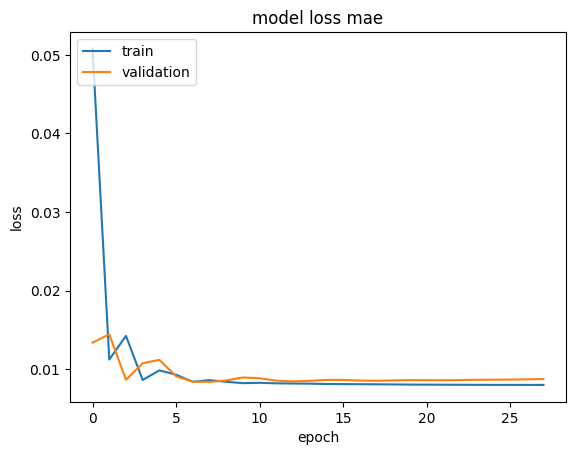

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 16)                1216      
                                                                 
 dense_62 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,233
Trainable params: 1,233
Non-trainable params: 0
_________________________________________________________________
Test MAE: 1.610
Test RMSE: 2.333
Test MAPE: 2.925
Test R2: 0.092


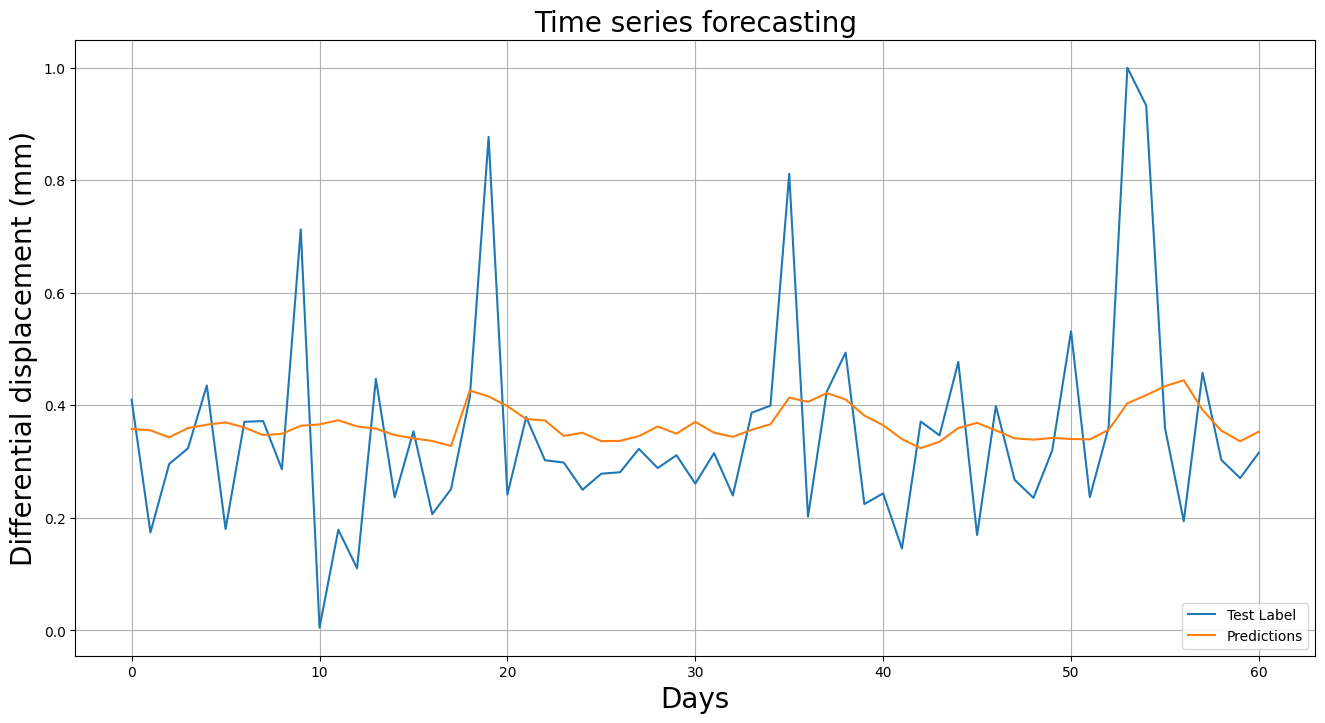

-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
LSTM
Filters:  16
Learning rate:  0.01
Batch size:  18
Look back:  5
(156, 12)
(95, 10) 95 (95,)
(95, 5, 2) (95,) (61, 5, 2) (61,)
Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 16)                1216      
                                                                 
 dense_63 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,233
Trainable params: 1,233
Non-trainable params: 0
_________________________________________________________________


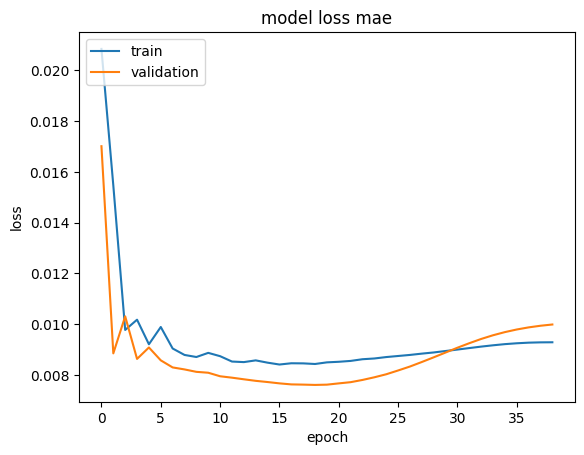

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_13 (LSTM)              (None, 16)                1216      
                                                                 
 dense_64 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,233
Trainable params: 1,233
Non-trainable params: 0
_________________________________________________________________
Test MAE: 1.620
Test RMSE: 2.362
Test MAPE: 3.101
Test R2: 0.069


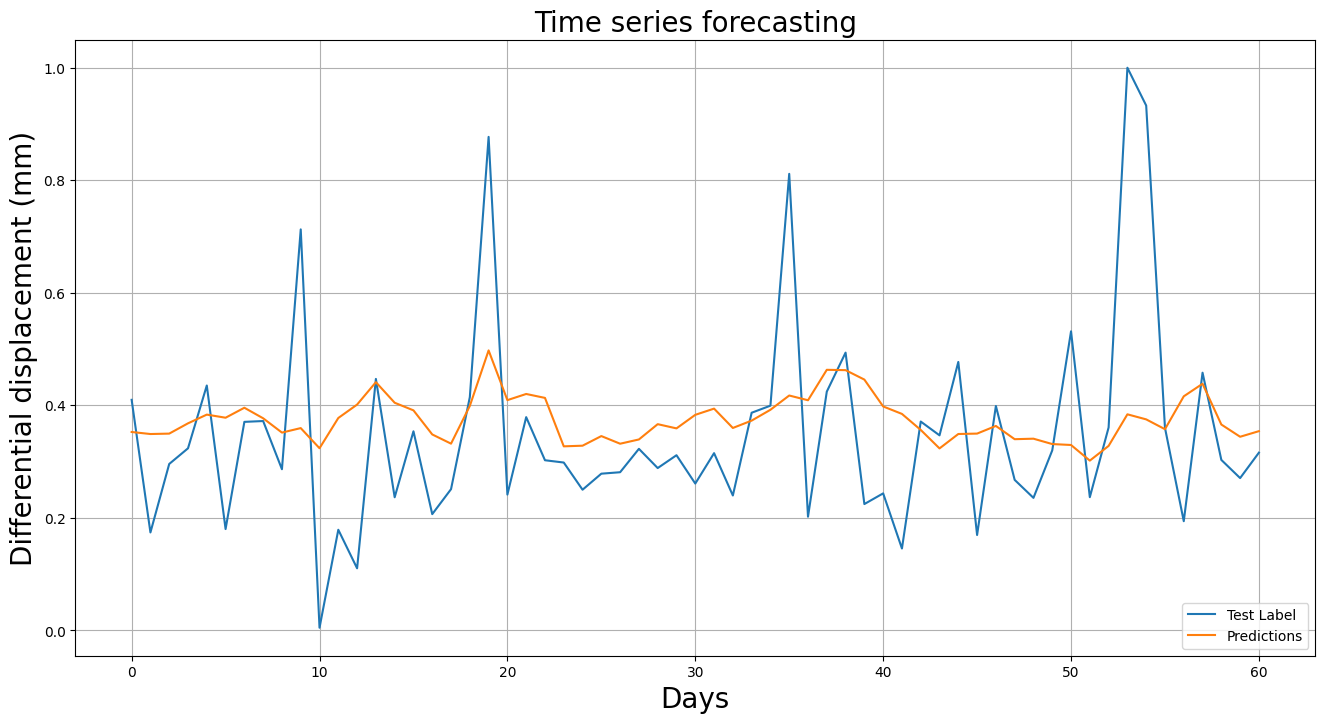

-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
LSTM
Filters:  16
Learning rate:  0.01
Batch size:  18
Look back:  7
(154, 16)
(93, 14) 93 (93,)
(93, 7, 2) (93,) (61, 7, 2) (61,)
Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 16)                1216      
                                                                 
 dense_65 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,233
Trainable params: 1,233
Non-trainable params: 0
_________________________________________________________________


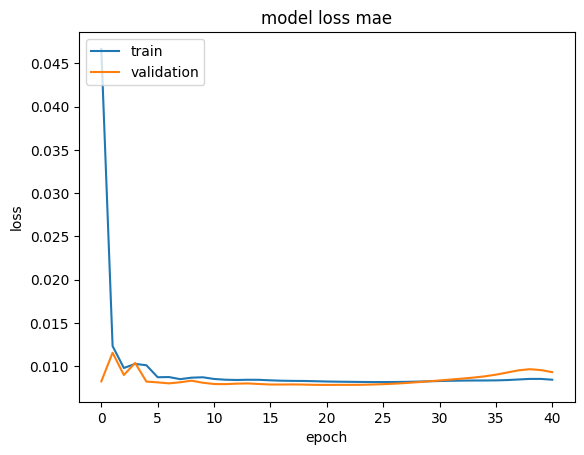

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 16)                1216      
                                                                 
 dense_66 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,233
Trainable params: 1,233
Non-trainable params: 0
_________________________________________________________________
Test MAE: 1.501
Test RMSE: 2.262
Test MAPE: 2.405
Test R2: 0.147


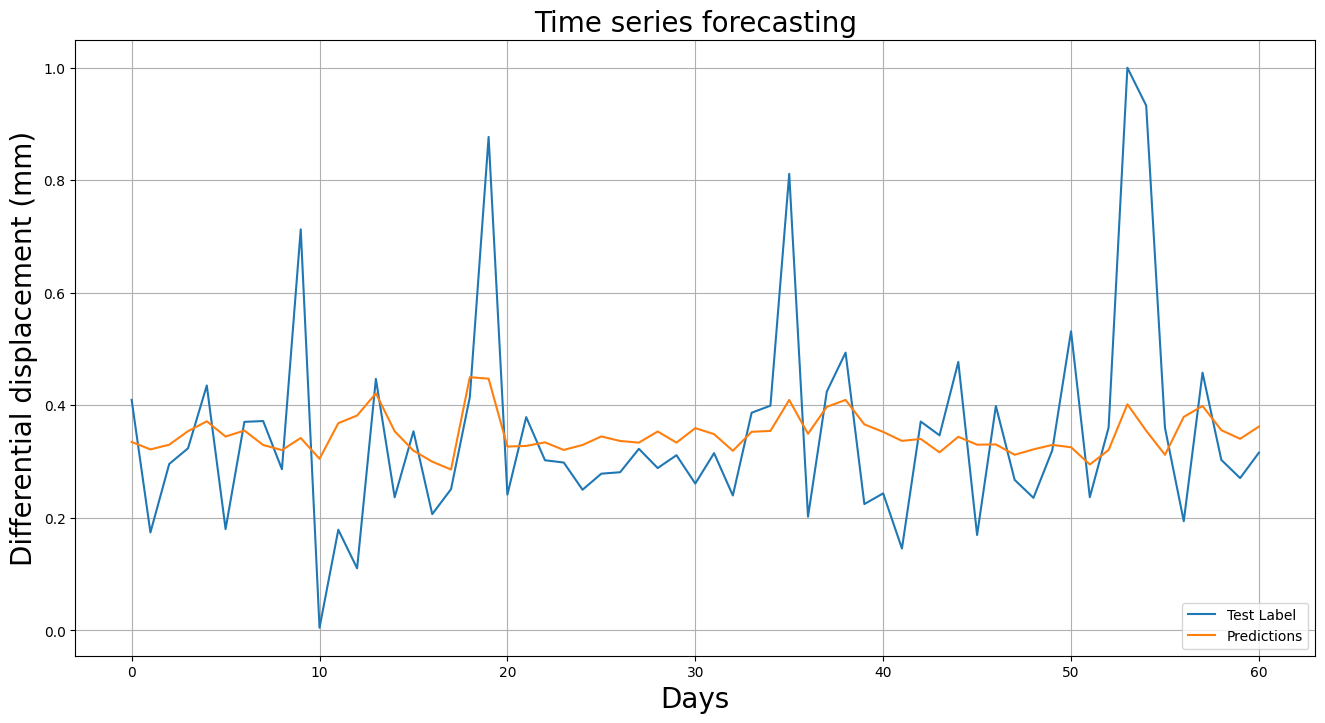

-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
LSTM
Filters:  16
Learning rate:  0.01
Batch size:  18
Look back:  9
(152, 20)
(91, 18) 91 (91,)
(91, 9, 2) (91,) (61, 9, 2) (61,)
Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 16)                1216      
                                                                 
 dense_67 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,233
Trainable params: 1,233
Non-trainable params: 0
_________________________________________________________________


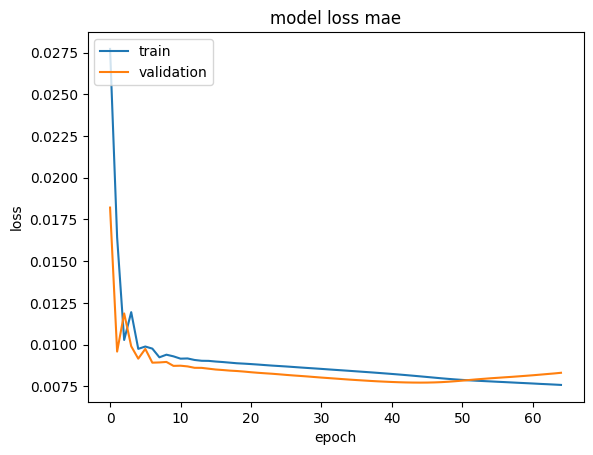

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_17 (LSTM)              (None, 16)                1216      
                                                                 
 dense_68 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,233
Trainable params: 1,233
Non-trainable params: 0
_________________________________________________________________
Test MAE: 1.534
Test RMSE: 2.301
Test MAPE: 2.540
Test R2: 0.117


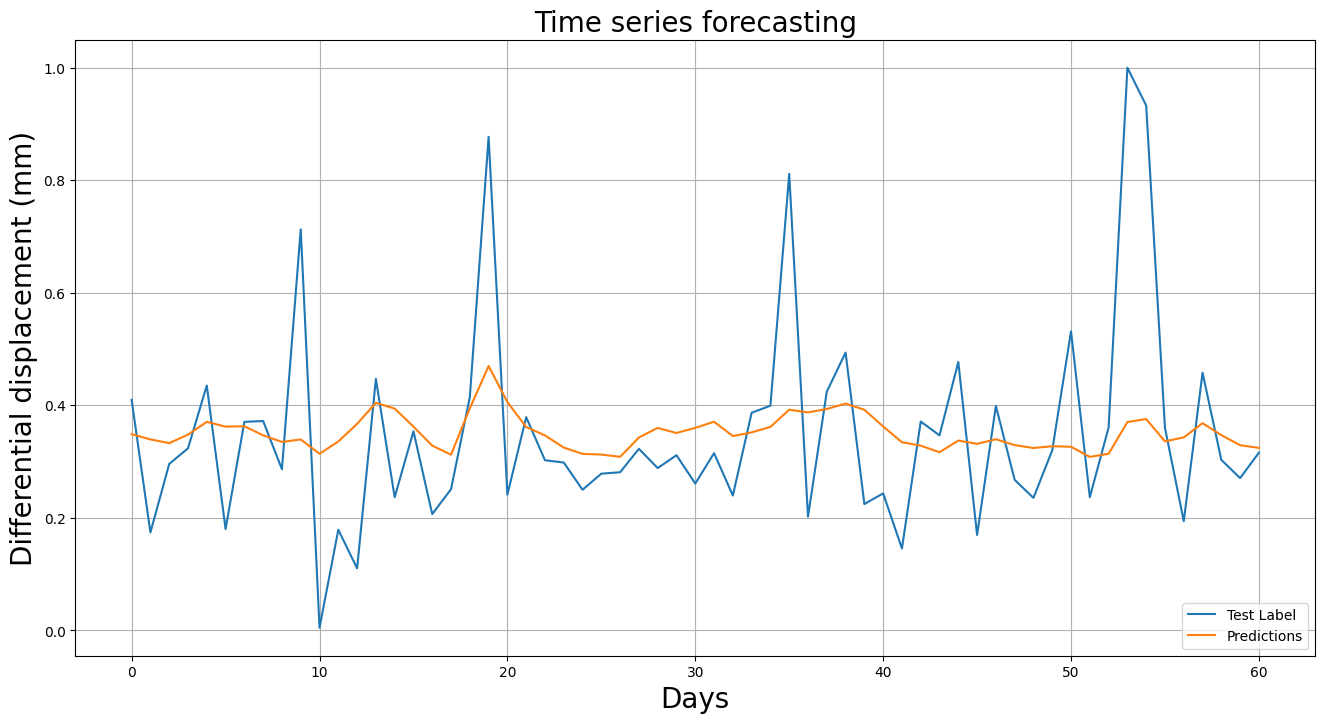

-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
LSTM
Filters:  16
Learning rate:  0.01
Batch size:  18
Look back:  12
(149, 26)
(88, 24) 88 (88,)
(88, 12, 2) (88,) (61, 12, 2) (61,)
Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 16)                1216      
                                                                 
 dense_69 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,233
Trainable params: 1,233
Non-trainable params: 0
_________________________________________________________________


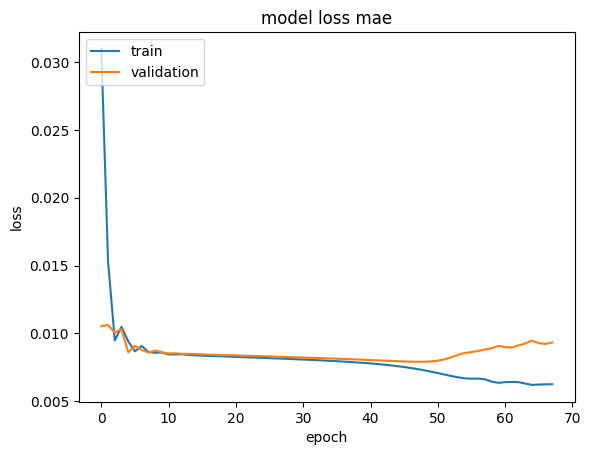

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_19 (LSTM)              (None, 16)                1216      
                                                                 
 dense_70 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,233
Trainable params: 1,233
Non-trainable params: 0
_________________________________________________________________
Test MAE: 1.531
Test RMSE: 2.311
Test MAPE: 2.211
Test R2: 0.109


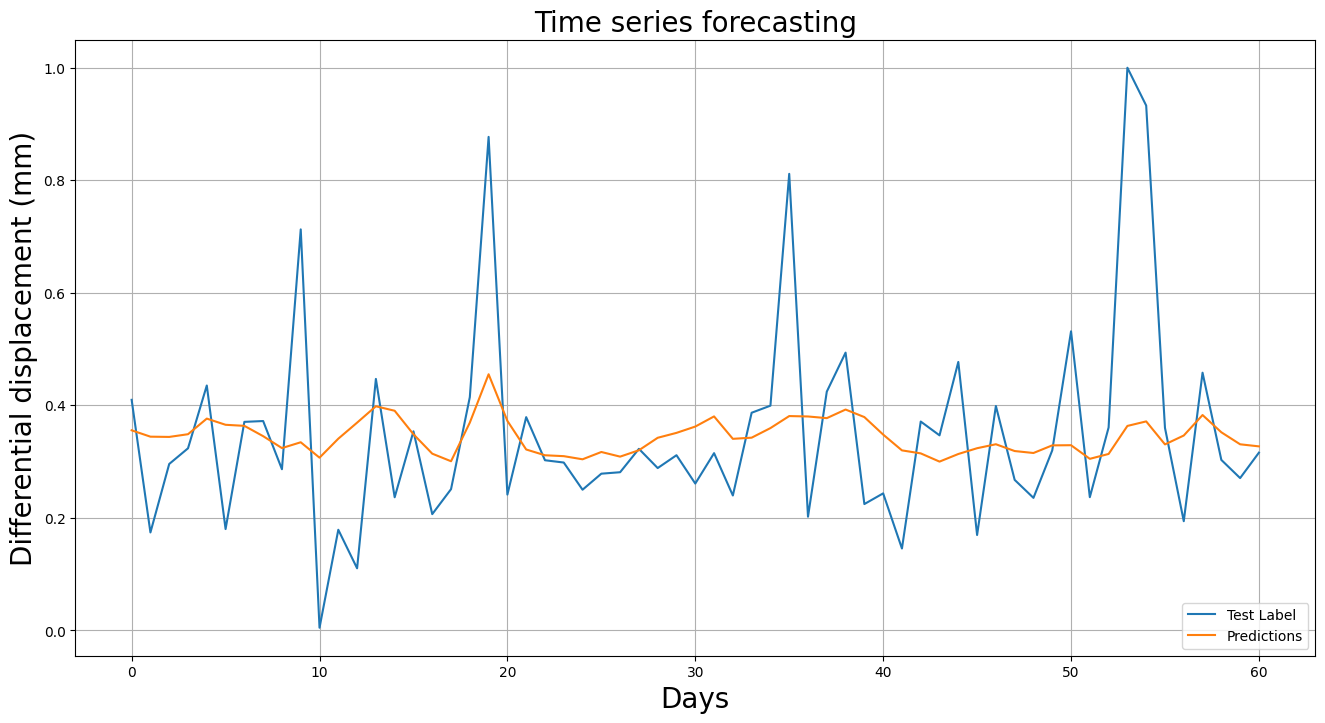

-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
LSTM
Filters:  16
Learning rate:  0.01
Batch size:  36
Look back:  3
(158, 8)
(97, 6) 97 (97,)
(97, 3, 2) (97,) (61, 3, 2) (61,)
Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 16)                1216      
                                                                 
 dense_71 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,233
Trainable params: 1,233
Non-trainable params: 0
_________________________________________________________________


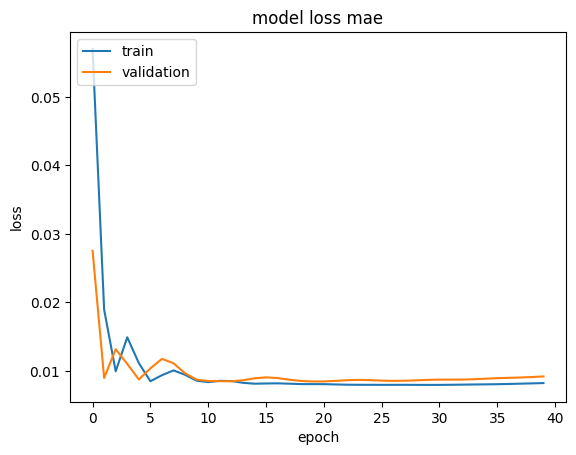

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_21 (LSTM)              (None, 16)                1216      
                                                                 
 dense_72 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,233
Trainable params: 1,233
Non-trainable params: 0
_________________________________________________________________
Test MAE: 1.546
Test RMSE: 2.272
Test MAPE: 2.530
Test R2: 0.139


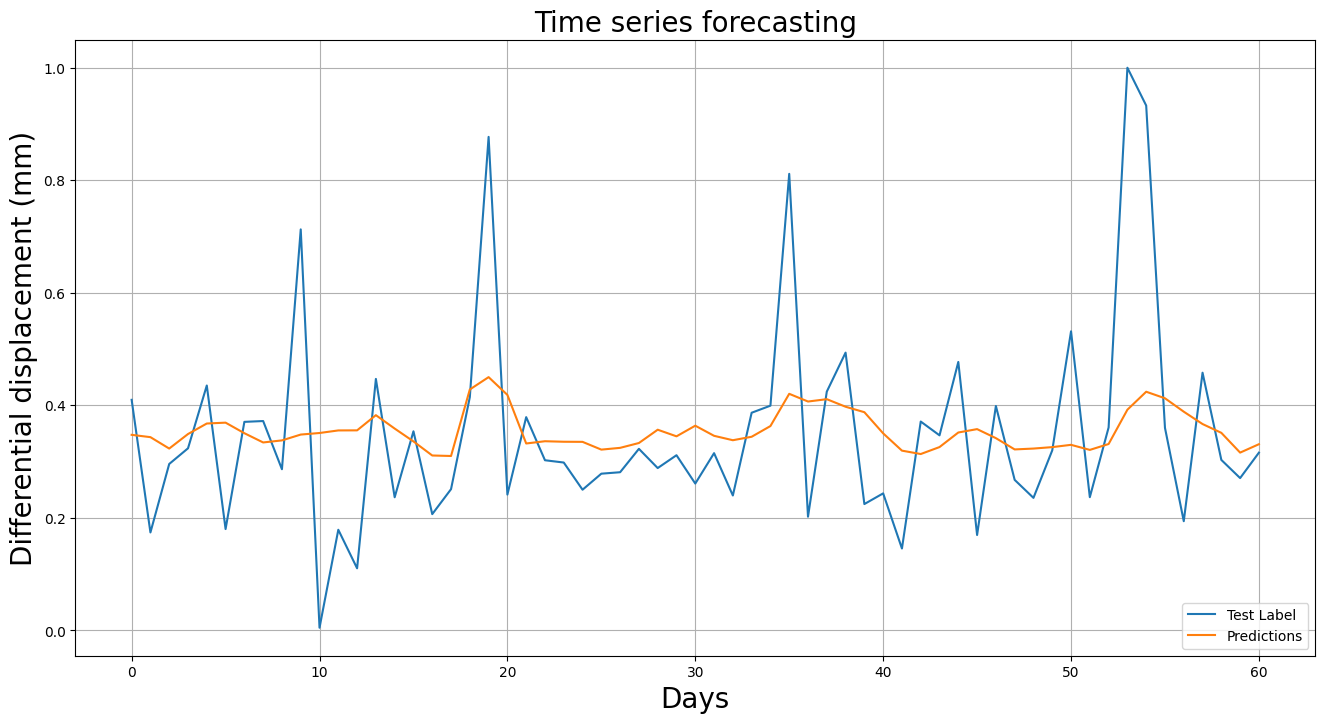

-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
LSTM
Filters:  16
Learning rate:  0.01
Batch size:  36
Look back:  5
(156, 12)
(95, 10) 95 (95,)
(95, 5, 2) (95,) (61, 5, 2) (61,)
Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 16)                1216      
                                                                 
 dense_73 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,233
Trainable params: 1,233
Non-trainable params: 0
_________________________________________________________________


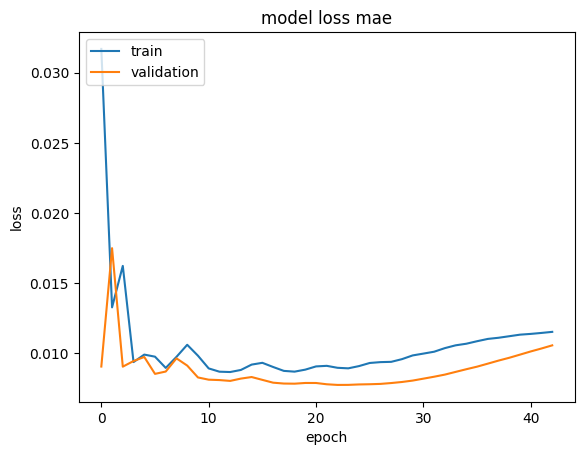

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_23 (LSTM)              (None, 16)                1216      
                                                                 
 dense_74 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,233
Trainable params: 1,233
Non-trainable params: 0
_________________________________________________________________
Test MAE: 1.771
Test RMSE: 2.412
Test MAPE: 3.749
Test R2: 0.029


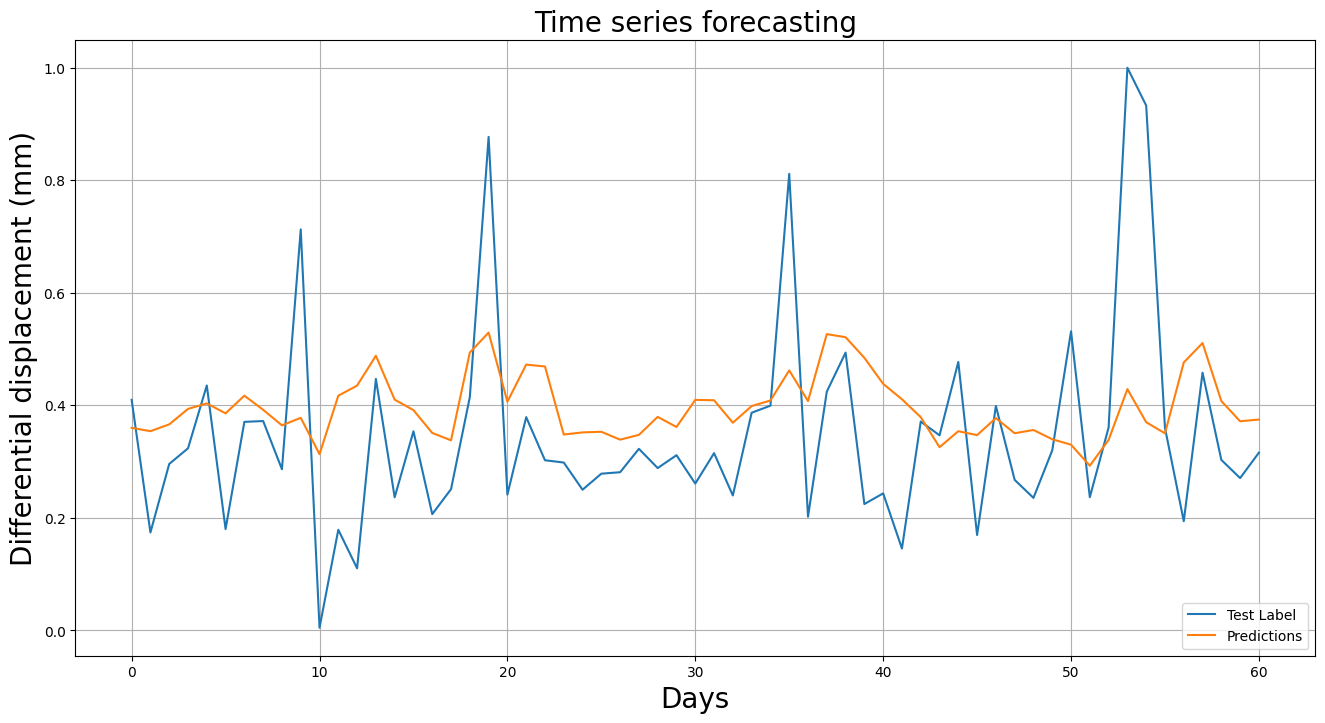

-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
LSTM
Filters:  16
Learning rate:  0.01
Batch size:  36
Look back:  7
(154, 16)
(93, 14) 93 (93,)
(93, 7, 2) (93,) (61, 7, 2) (61,)
Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 16)                1216      
                                                                 
 dense_75 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,233
Trainable params: 1,233
Non-trainable params: 0
_________________________________________________________________


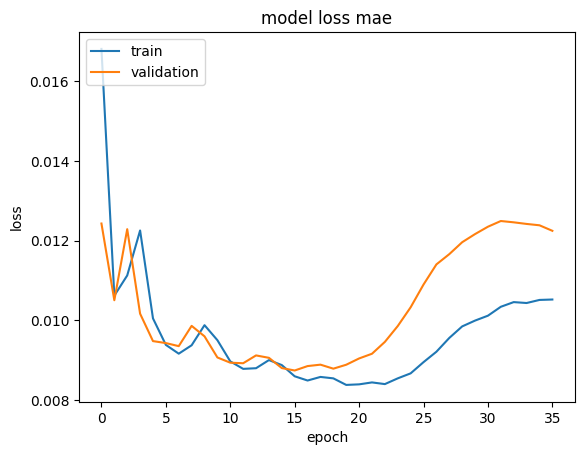

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_25 (LSTM)              (None, 16)                1216      
                                                                 
 dense_76 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,233
Trainable params: 1,233
Non-trainable params: 0
_________________________________________________________________
Test MAE: 1.587
Test RMSE: 2.440
Test MAPE: 2.000
Test R2: 0.007


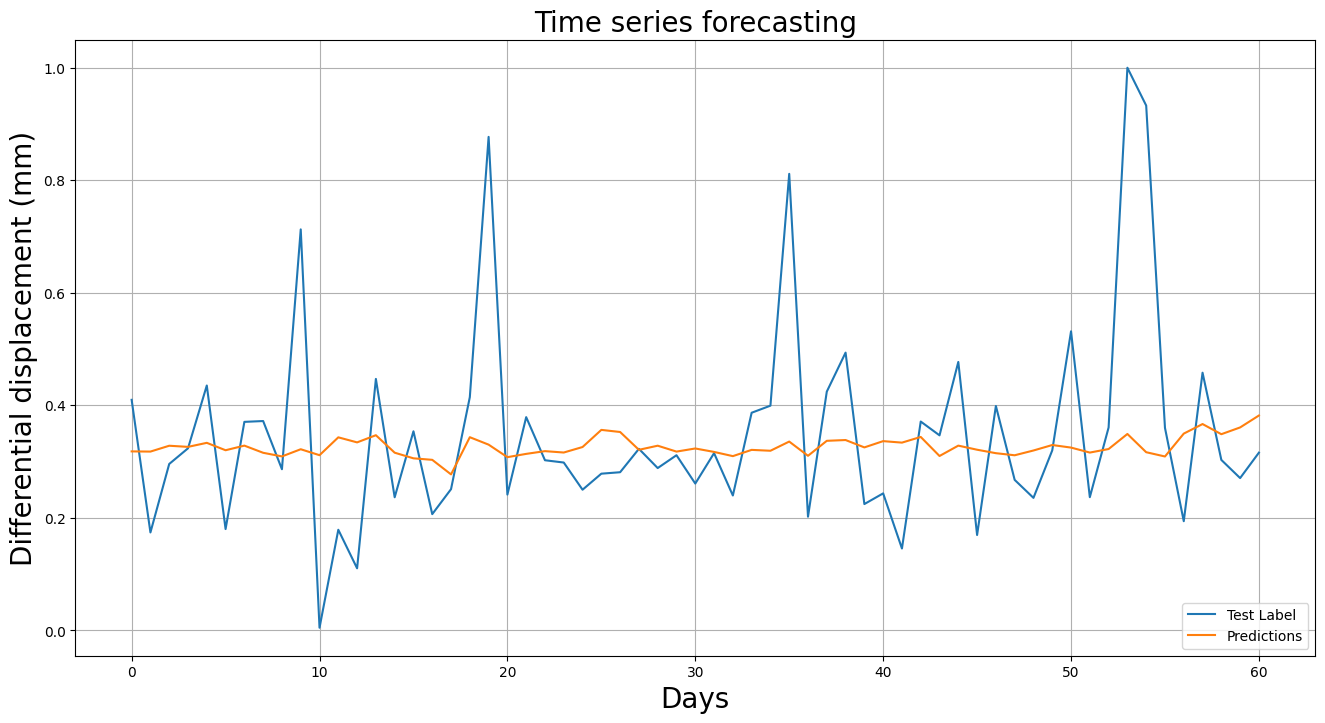

-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
LSTM
Filters:  16
Learning rate:  0.01
Batch size:  36
Look back:  9
(152, 20)
(91, 18) 91 (91,)
(91, 9, 2) (91,) (61, 9, 2) (61,)
Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_26 (LSTM)              (None, 16)                1216      
                                                                 
 dense_77 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,233
Trainable params: 1,233
Non-trainable params: 0
_________________________________________________________________


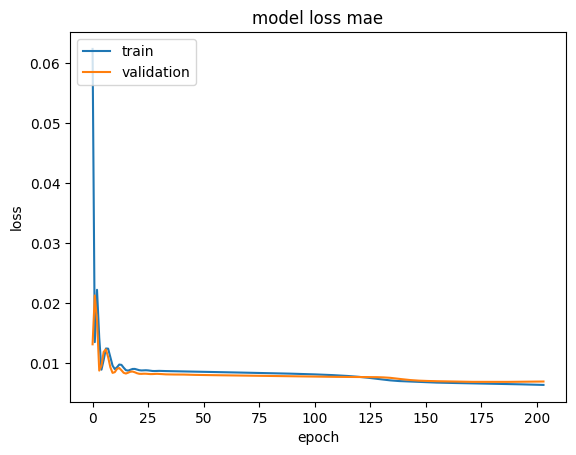

Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_27 (LSTM)              (None, 16)                1216      
                                                                 
 dense_78 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,233
Trainable params: 1,233
Non-trainable params: 0
_________________________________________________________________
Test MAE: 1.628
Test RMSE: 2.373
Test MAPE: 2.995
Test R2: 0.061


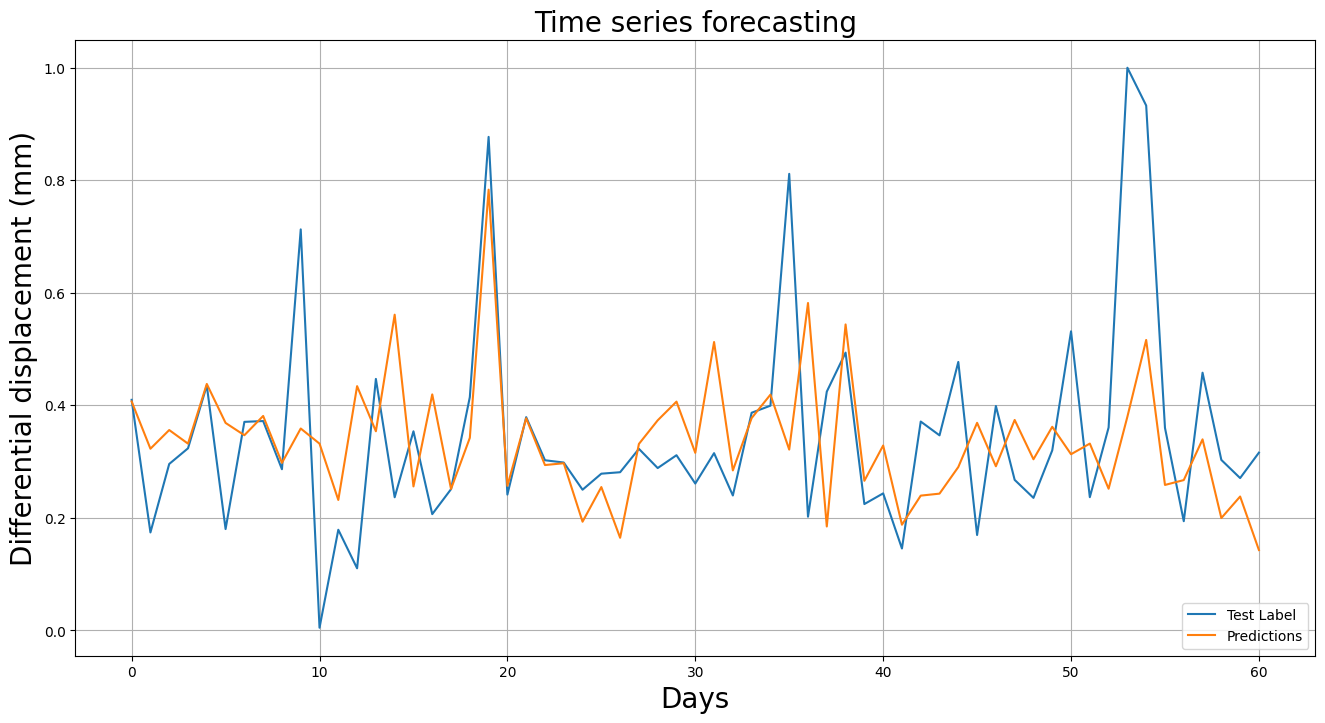

-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
LSTM
Filters:  16
Learning rate:  0.01
Batch size:  36
Look back:  12
(149, 26)
(88, 24) 88 (88,)
(88, 12, 2) (88,) (61, 12, 2) (61,)
Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, 16)                1216      
                                                                 
 dense_79 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,233
Trainable params: 1,233
Non-trainable params: 0
_________________________________________________________________


KeyboardInterrupt: 

In [14]:
### LSTM ###


dic = {}

# number of filters/nodes
filters = [16, 32, 64, 96, 128, 256]
# learning rates
lr = [10e-3, 5e-3, 10e-4, 5e-4, 10e-5, 5e-5]
# epochs
epochs = 1000
# batch sizes
batch_size = [9, 18, 36, 72, 144]
# how many time steps back do we want the model to see
look_backs = [3, 5, 7, 9, 12]

# Hyperparameters
dic["batch_size"] = []
dic["learning_rate"] = []
dic["filters"] = []
dic["look_backs"] = []

# test_scores
dic["MAE"] = []
dic["RMSE"] = []
dic["MAPE"] = []
dic["R2"] = []

for fil in filters:
    for learning_rate in lr:
        for batch in batch_size:
            for look in look_backs:
                print('-------------------------------------------------------------------------------------')
                print('LSTM')
                print('Filters: ', fil)
                print('Learning rate: ', learning_rate)
                print('Batch size: ', batch)
                print('Look back: ', look)
                # load dataset
                values = dataset.values
                # ensure all data is float
                values = values.astype('float32')
                # normalize features
                scaler = MinMaxScaler(feature_range=(0, 1))
                scaled = scaler.fit_transform(values)
                # specify the number of lag hours
                n_hours = look
                # frame as supervised learning
                reframed = series_to_supervised(scaled, n_hours, 1)
                print(reframed.shape)

                # split into train and test sets
                values = reframed.values
                n_train_hours = hours_train - look
                train = values[:n_train_hours, :]
                test = values[n_train_hours:, :]
                # split into input and outputs
                n_obs = n_hours * n_features
                train_X, train_y = train[:, :n_obs], train[:, -n_features]
                test_X, test_y = test[:, :n_obs], test[:, -n_features]
                print(train_X.shape, len(train_X), train_y.shape)

                # reshape input to be 3D [samples, timesteps, features]
                train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
                test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
                print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

                n = - n_features + 1


                def LSTM_net(filters, lr):
                    model = Sequential()
                    model.add(LSTM(filters, return_sequences=False, input_shape=(train_X.shape[1], train_X.shape[2])))
                    model.add(Dense(1))
                    model.compile(loss=tf.losses.Huber(),
                                  optimizer=tf.optimizers.Adam(learning_rate=lr),
                                  metrics=[tf.metrics.MeanAbsoluteError(), tf.metrics.MeanSquaredError()])
                    model.summary()
                    return model


                # load the model
                model = LSTM_net(filters=fil, lr=learning_rate)
                # Save the models only when validation loss decrease
                early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',  # what is the metric to measure
                                                              patience=20,
                                                              # how many epochs to continue running the model after seeing an increase in val_loss
                                                              restore_best_weights=True)  # update the model weights
                model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                    f'models/LSTM/weights/filters_{fil}_batch_size_{batch}_lr_{learning_rate}_look_back_{look}.hdf5',
                    monitor='val_loss', mode='min', verbose=0,
                    save_best_only=True, save_weights_only=True)
                # fit network
                history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch, validation_split=0.2, verbose=0,
                                    shuffle=False, callbacks=[model_checkpoint, early_stop])

                plt.plot(history.history['loss'])
                plt.plot(history.history['val_loss'])
                plt.title('model loss mae')
                plt.ylabel('loss')
                plt.xlabel('epoch')
                plt.legend(['train', 'validation'], loc='upper left')
                # save plots
                plt.savefig(f"models/LSTM/plots/filters_{fil}_batch_size_{batch}_lr_{learning_rate}_look_back_{look}.png")
                plt.show()

                # load model to evaluate the test data
                LSTM_model = LSTM_net(filters=fil, lr=learning_rate)
                # load the last saved weight from the training
                LSTM_model.load_weights(f"models/LSTM/weights/filters_{fil}_batch_size_{batch}_lr_{learning_rate}_look_back_{look}.hdf5")

                # Evaluate the model
                yhat = LSTM_model.predict(test_X)
                test_X_res = test_X.reshape((test_X.shape[0], n_hours * n_features))
                # invert scaling for forecast
                inv_yhat = concatenate((yhat, test_X_res[:, n:]), axis=1)
                inv_yhat = scaler.inverse_transform(inv_yhat)
                inv_yhat = inv_yhat[:, 0]
                # invert scaling for actual
                test_y = test_y.reshape((len(test_y), 1))
                inv_y = concatenate((test_y, test_X_res[:, n:]), axis=1)
                inv_y = scaler.inverse_transform(inv_y)
                inv_y = inv_y[:, 0]

                # calculate MAE
                mae = mean_absolute_error(inv_y, inv_yhat)
                print('Test MAE: %.3f' % mae)
                # calculate RMSE
                rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
                print('Test RMSE: %.3f' % rmse)
                # calculate MAPE
                mape = mean_absolute_percentage_error(inv_y, inv_yhat)
                print('Test MAPE: %.3f' % mape)
                # calculate R2
                r2 = r2_score(inv_y, inv_yhat)
                print('Test R2: %.3f' % r2)

                # plot and save preds
                plt.figure(figsize=(16, 8))
                plt.title('Time series forecasting', size=20)
                # plt.ylim([0,1.3])
                plt.plot(pd.DataFrame(test_y), label='Test Label')
                plt.plot(pd.DataFrame(yhat), label='Predictions')
                plt.legend(loc='lower right', markerscale=1)
                plt.xlabel('Time step', size=20)
                plt.ylabel('Differential displacement (mm)', size=20)
                plt.grid(True)
                plt.savefig(f"models/LSTM/preds/filters_{fil}_batch_size_{batch}_lr_{learning_rate}_look_back_{look}.png",
                            facecolor='white', edgecolor='none', bbox_inches='tight')
                plt.show()

                # save results on the dictionary
                dic["batch_size"].append(batch)
                dic["learning_rate"].append(learning_rate)
                dic["filters"].append(fil)
                dic["look_backs"].append(look)
                dic["MAE"].append(mae)
                dic["RMSE"].append(rmse)
                dic["MAPE"].append(mape)
                dic["R2"].append(r2)
                # Convert results to a dataframe
                results = pd.DataFrame(dic)
                # Export as csv
                results.to_csv(f'models/LSTM/results/LSTM_results.csv', index=False)
                print('-------------------------------------------------------------------------------------')

print('LSTM finished!')

-------------------------------------------------------------------------------------
GRU
Filters:  16
Learning rate:  0.01
Batch size:  9
Look back:  3
(158, 8)
(97, 6) 97 (97,)
(97, 3, 2) (97,) (61, 3, 2) (61,)
Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 16)                960       
                                                                 
 dense_80 (Dense)            (None, 1)                 17        
                                                                 
Total params: 977
Trainable params: 977
Non-trainable params: 0
_________________________________________________________________


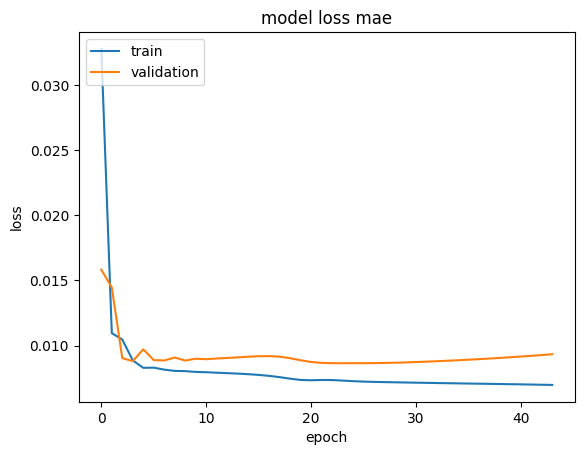

Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 16)                960       
                                                                 
 dense_81 (Dense)            (None, 1)                 17        
                                                                 
Total params: 977
Trainable params: 977
Non-trainable params: 0
_________________________________________________________________
Test MAE: 1.534
Test RMSE: 2.289
Test MAPE: 2.447
Test R2: 0.126


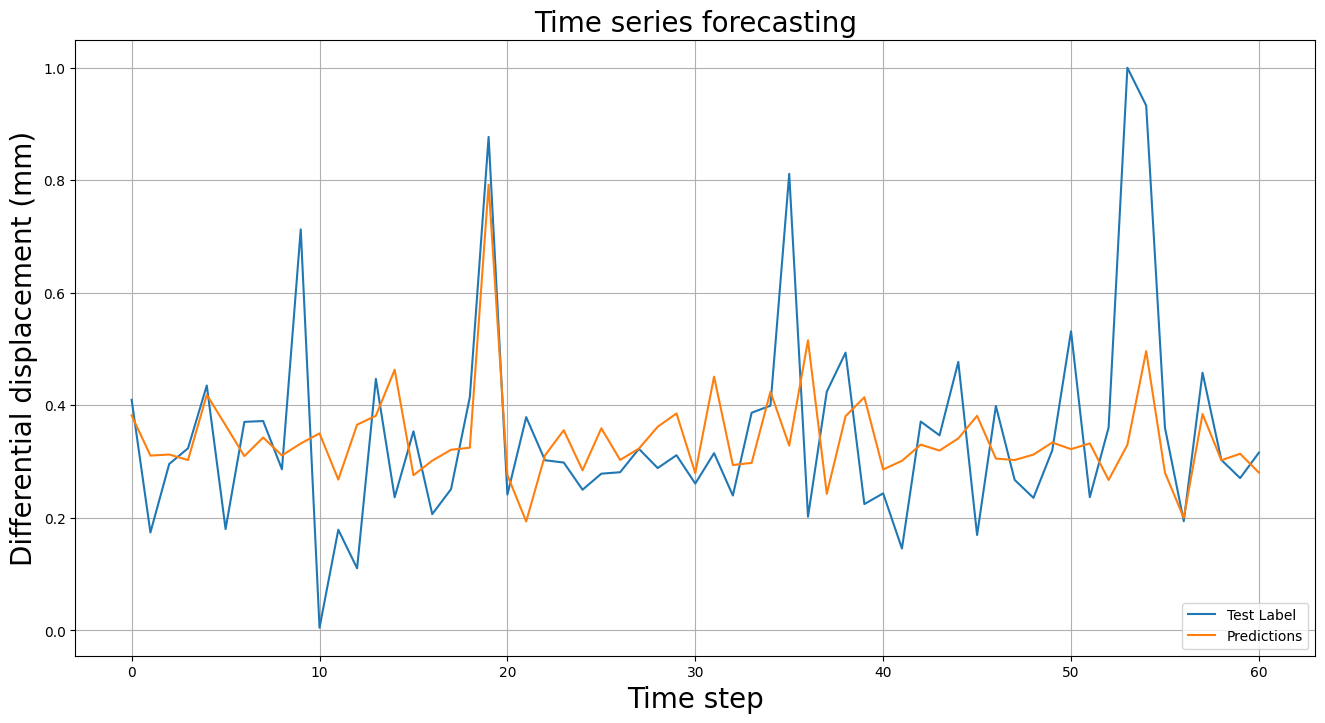

-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
GRU
Filters:  16
Learning rate:  0.01
Batch size:  9
Look back:  5
(156, 12)
(95, 10) 95 (95,)
(95, 5, 2) (95,) (61, 5, 2) (61,)
Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 16)                960       
                                                                 
 dense_82 (Dense)            (None, 1)                 17        
                                                                 
Total params: 977
Trainable params: 977
Non-trainable params: 0
_________________________________________________________________


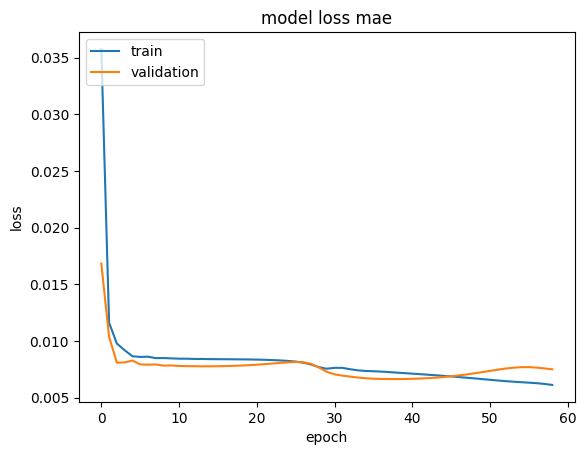

Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 16)                960       
                                                                 
 dense_83 (Dense)            (None, 1)                 17        
                                                                 
Total params: 977
Trainable params: 977
Non-trainable params: 0
_________________________________________________________________
Test MAE: 1.744
Test RMSE: 2.530
Test MAPE: 2.583
Test R2: -0.067


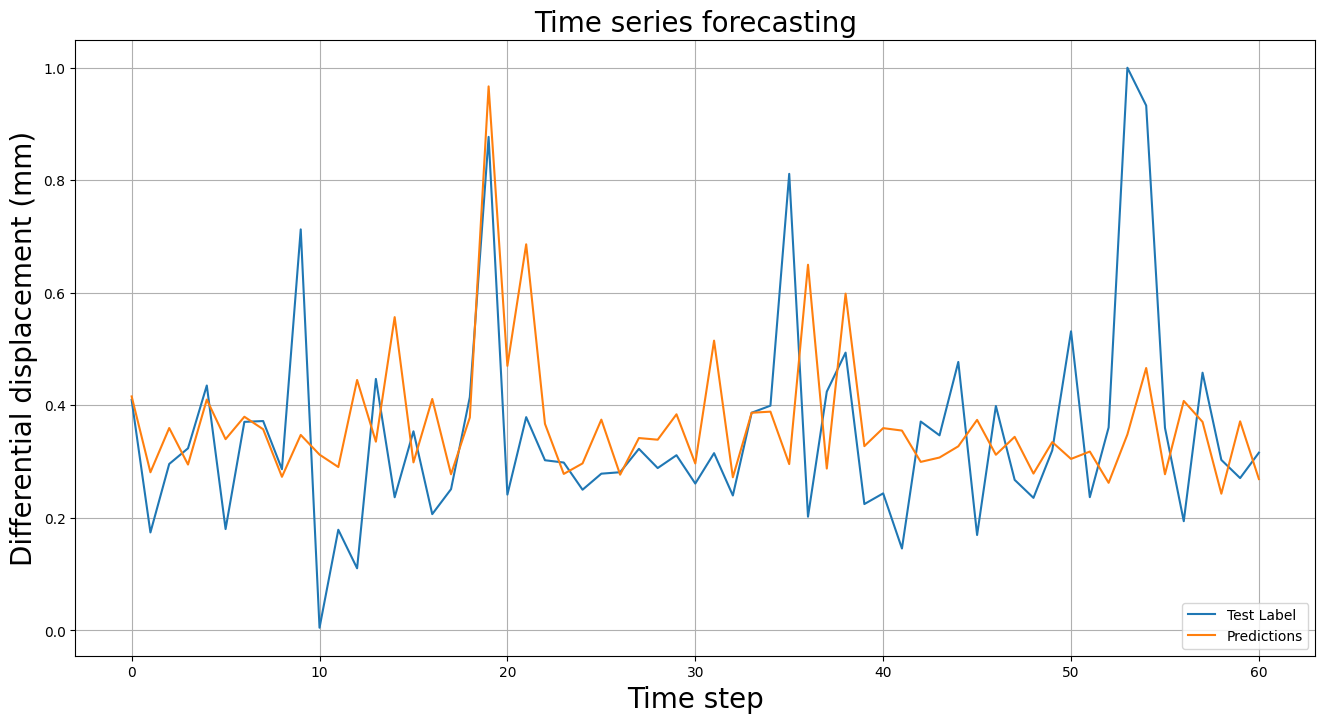

-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
GRU
Filters:  16
Learning rate:  0.01
Batch size:  9
Look back:  7
(154, 16)
(93, 14) 93 (93,)
(93, 7, 2) (93,) (61, 7, 2) (61,)
Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 16)                960       
                                                                 
 dense_84 (Dense)            (None, 1)                 17        
                                                                 
Total params: 977
Trainable params: 977
Non-trainable params: 0
_________________________________________________________________


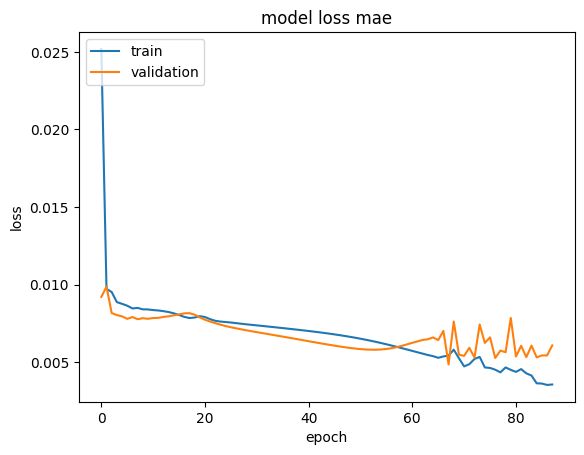

Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_5 (GRU)                 (None, 16)                960       
                                                                 
 dense_85 (Dense)            (None, 1)                 17        
                                                                 
Total params: 977
Trainable params: 977
Non-trainable params: 0
_________________________________________________________________
Test MAE: 1.888
Test RMSE: 2.561
Test MAPE: 3.338
Test R2: -0.094


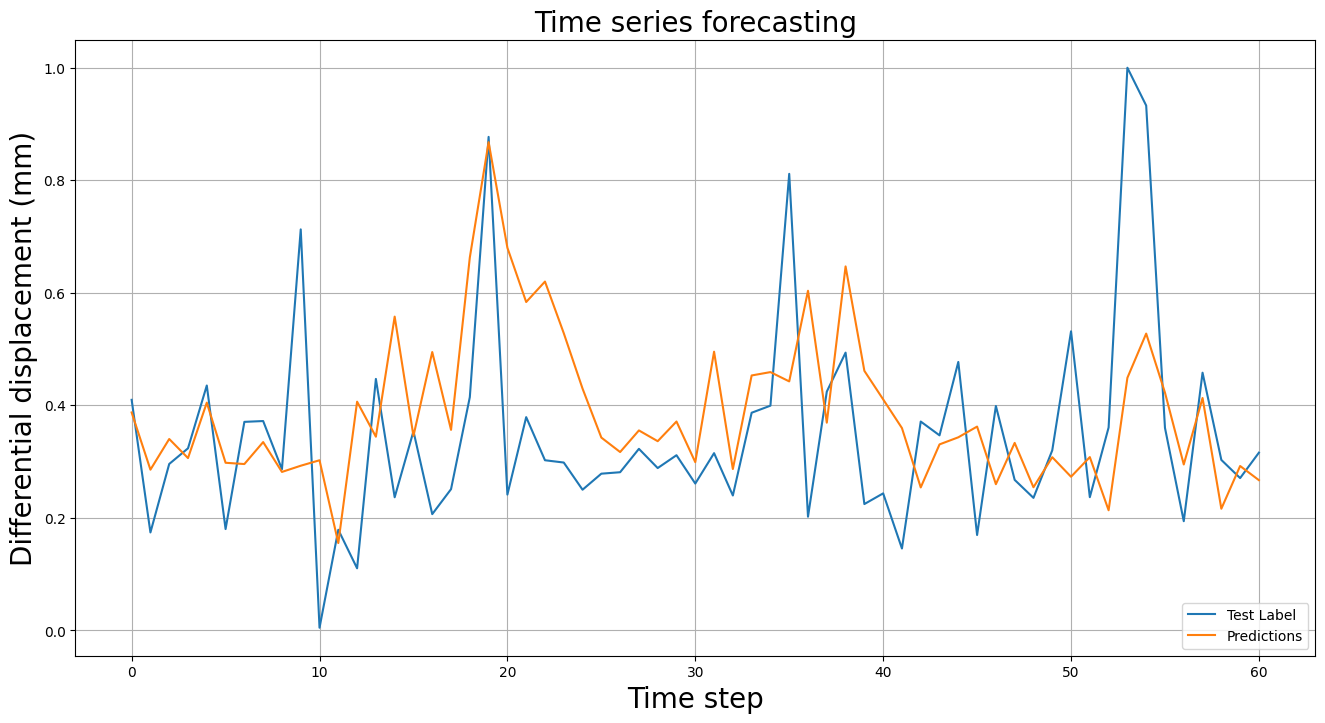

-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
GRU
Filters:  16
Learning rate:  0.01
Batch size:  9
Look back:  9
(152, 20)
(91, 18) 91 (91,)
(91, 9, 2) (91,) (61, 9, 2) (61,)
Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_6 (GRU)                 (None, 16)                960       
                                                                 
 dense_86 (Dense)            (None, 1)                 17        
                                                                 
Total params: 977
Trainable params: 977
Non-trainable params: 0
_________________________________________________________________


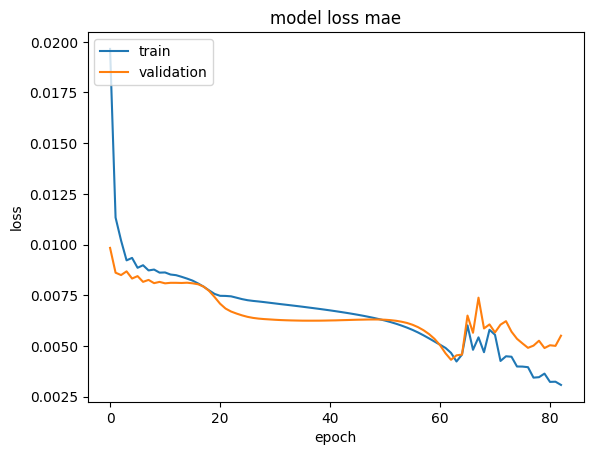

Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_7 (GRU)                 (None, 16)                960       
                                                                 
 dense_87 (Dense)            (None, 1)                 17        
                                                                 
Total params: 977
Trainable params: 977
Non-trainable params: 0
_________________________________________________________________
Test MAE: 2.783
Test RMSE: 3.750
Test MAPE: 6.207
Test R2: -1.346


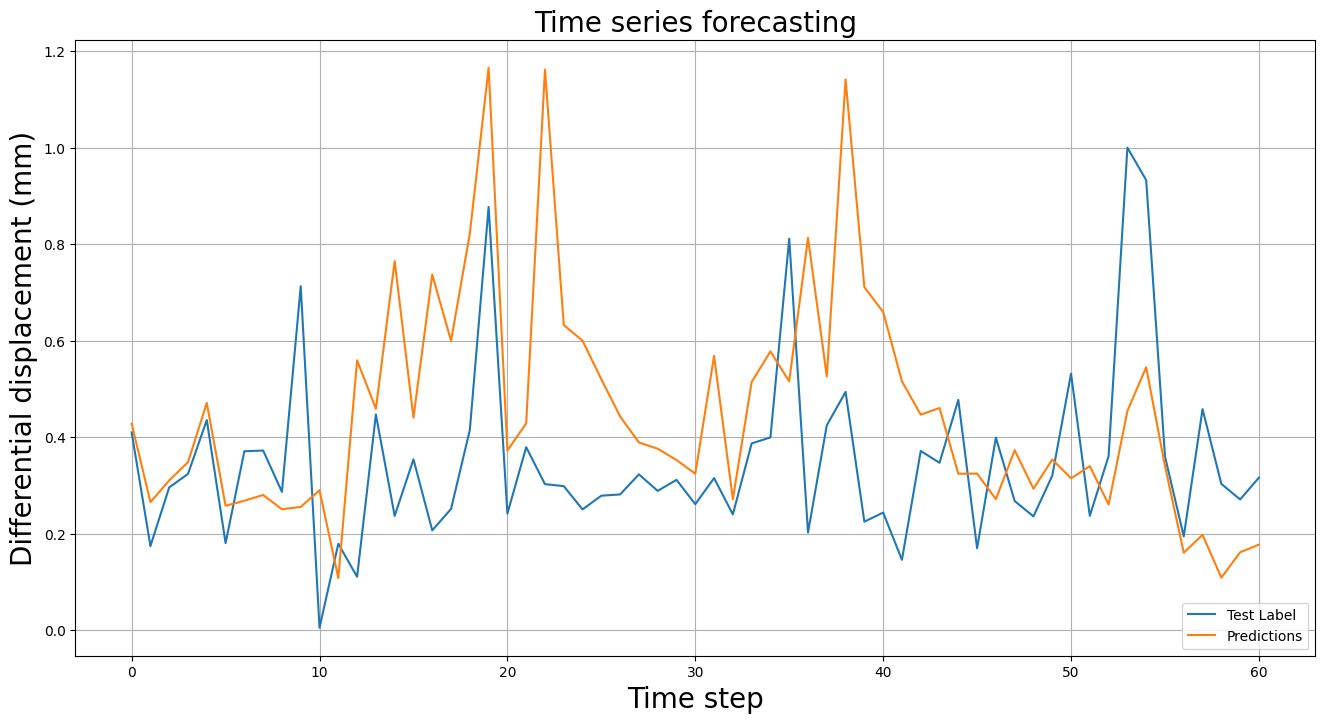

-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
GRU
Filters:  16
Learning rate:  0.01
Batch size:  9
Look back:  12
(149, 26)
(88, 24) 88 (88,)
(88, 12, 2) (88,) (61, 12, 2) (61,)
Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_8 (GRU)                 (None, 16)                960       
                                                                 
 dense_88 (Dense)            (None, 1)                 17        
                                                                 
Total params: 977
Trainable params: 977
Non-trainable params: 0
_________________________________________________________________


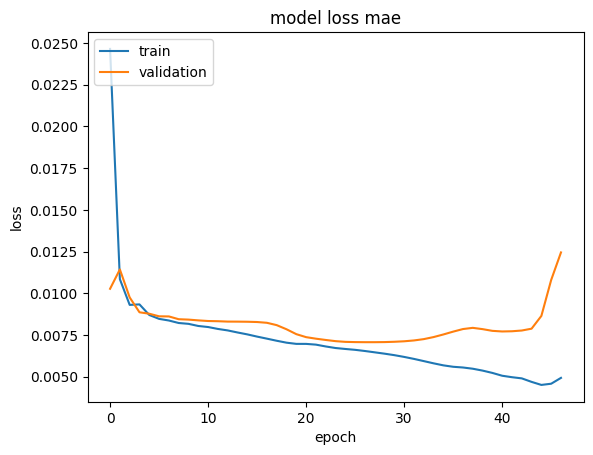

Model: "sequential_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_9 (GRU)                 (None, 16)                960       
                                                                 
 dense_89 (Dense)            (None, 1)                 17        
                                                                 
Total params: 977
Trainable params: 977
Non-trainable params: 0
_________________________________________________________________
Test MAE: 1.516
Test RMSE: 2.279
Test MAPE: 2.094
Test R2: 0.134


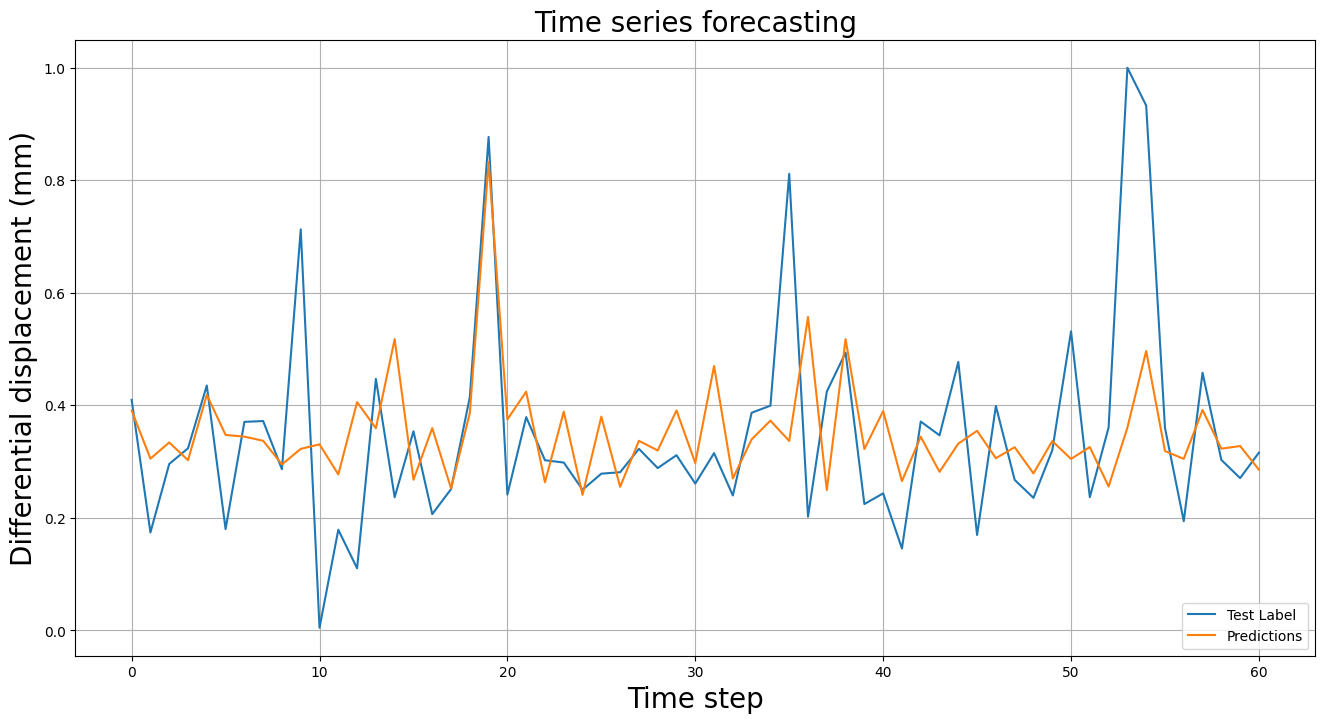

-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
GRU
Filters:  16
Learning rate:  0.01
Batch size:  18
Look back:  3
(158, 8)
(97, 6) 97 (97,)
(97, 3, 2) (97,) (61, 3, 2) (61,)
Model: "sequential_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_10 (GRU)                (None, 16)                960       
                                                                 
 dense_90 (Dense)            (None, 1)                 17        
                                                                 
Total params: 977
Trainable params: 977
Non-trainable params: 0
_________________________________________________________________


KeyboardInterrupt: 

In [15]:
### GRU ###


dic = {}

# number of filters/nodes
filters = [16, 32, 64, 96, 128, 256]
# learning rates
lr = [10e-3, 5e-3, 10e-4, 5e-4, 10e-5, 5e-5]
# epochs
epochs = 1000
# batch sizes
batch_size = [9, 18, 36, 72, 144]
# how many time steps back do we want the model to see
look_backs = [3, 5, 7, 9, 12]

# Hyperparameters
dic["batch_size"] = []
dic["learning_rate"] = []
dic["filters"] = []
dic["look_backs"] = []

# test_scores
dic["MAE"] = []
dic["RMSE"] = []
dic["MAPE"] = []
dic["R2"] = []

for fil in filters:
    for learning_rate in lr:
        for batch in batch_size:
            for look in look_backs:
                print('-------------------------------------------------------------------------------------')
                print('GRU')
                print('Filters: ', fil)
                print('Learning rate: ', learning_rate)
                print('Batch size: ', batch)
                print('Look back: ', look)

                # load dataset
                values = dataset.values
                # ensure all data is float
                values = values.astype('float32')
                # normalize features
                scaler = MinMaxScaler(feature_range=(0, 1))
                scaled = scaler.fit_transform(values)
                # specify the number of lag hours
                n_hours = look
                # frame as supervised learning
                reframed = series_to_supervised(scaled, n_hours, 1)
                print(reframed.shape)

                # split into train and test sets
                values = reframed.values
                n_train_hours = hours_train - look
                train = values[:n_train_hours, :]
                test = values[n_train_hours:, :]
                # split into input and outputs
                n_obs = n_hours * n_features
                train_X, train_y = train[:, :n_obs], train[:, -n_features]
                test_X, test_y = test[:, :n_obs], test[:, -n_features]
                print(train_X.shape, len(train_X), train_y.shape)

                # reshape input to be 3D [samples, timesteps, features]
                train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
                test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
                print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

                n = - n_features + 1


                def GRU_net(filters, lr):
                    model = Sequential()
                    model.add(
                        GRU(units=filters, return_sequences=False, input_shape=(train_X.shape[1], train_X.shape[2])))
                    model.add(Dense(units=1))
                    model.compile(loss=tf.losses.Huber(),
                                  optimizer=tf.optimizers.Adam(learning_rate=lr),
                                  metrics=[tf.metrics.MeanAbsoluteError(), tf.metrics.MeanSquaredError()])
                    model.summary()
                    return model


                # load the model
                model = GRU_net(filters=fil, lr=learning_rate)
                # Save the models only when validation loss decrease
                early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',  # what is the metric to measure
                                                              patience=20,
                                                              # how many epochs to continue running the model after seeing an increase in val_loss
                                                              restore_best_weights=True)  # update the model weights
                model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                    f'models/GRU/weights/filters_{fil}_batch_size_{batch}_lr_{learning_rate}_look_back_{look}.hdf5',
                    monitor='val_loss', mode='min', verbose=0,
                    save_best_only=True, save_weights_only=True)
                # fit network
                history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch, validation_split=0.2, verbose=0,
                                    shuffle=False, callbacks=[model_checkpoint, early_stop])

                plt.plot(history.history['loss'])
                plt.plot(history.history['val_loss'])
                plt.title('model loss mae')
                plt.ylabel('loss')
                plt.xlabel('epoch')
                plt.legend(['train', 'validation'], loc='upper left')
                # save plots
                plt.savefig(f"models/GRU/plots/filters_{fil}_batch_size_{batch}_lr_{learning_rate}_look_back_{look}.png")
                plt.show()

                # load model to evaluate the test data
                GRU_model = GRU_net(filters=fil, lr=learning_rate)
                # load the last saved weight from the training
                GRU_model.load_weights(f"models/GRU/weights/filters_{fil}_batch_size_{batch}_lr_{learning_rate}_look_back_{look}.hdf5")

                # Evaluate the model
                yhat = GRU_model.predict(test_X)
                test_X_res = test_X.reshape((test_X.shape[0], n_hours * n_features))
                # invert scaling for forecast
                inv_yhat = concatenate((yhat, test_X_res[:, n:]), axis=1)
                inv_yhat = scaler.inverse_transform(inv_yhat)
                inv_yhat = inv_yhat[:, 0]
                # invert scaling for actual
                test_y = test_y.reshape((len(test_y), 1))
                inv_y = concatenate((test_y, test_X_res[:, n:]), axis=1)
                inv_y = scaler.inverse_transform(inv_y)
                inv_y = inv_y[:, 0]

                # calculate MAE
                mae = mean_absolute_error(inv_y, inv_yhat)
                print('Test MAE: %.3f' % mae)
                # calculate RMSE
                rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
                print('Test RMSE: %.3f' % rmse)
                # calculate MAPE
                mape = mean_absolute_percentage_error(inv_y, inv_yhat)
                print('Test MAPE: %.3f' % mape)
                # calculate R2
                r2 = r2_score(inv_y, inv_yhat)
                print('Test R2: %.3f' % r2)

                # plot and save preds
                plt.figure(figsize=(16, 8))
                plt.title('Time series forecasting', size=20)
                # plt.ylim([0,1.3])
                plt.plot(pd.DataFrame(test_y), label='Test Label')
                plt.plot(pd.DataFrame(yhat), label='Predictions')
                plt.legend(loc='lower right', markerscale=1)
                plt.xlabel('Time step', size=20)
                plt.ylabel('Differential displacement (mm)', size=20)
                plt.grid(True)
                plt.savefig(f"models/GRU/preds/filters_{fil}_batch_size_{batch}_lr_{learning_rate}_look_back_{look}.png",
                            facecolor='white', edgecolor='none', bbox_inches='tight')
                plt.show()

                # save results on the dictionary
                dic["batch_size"].append(batch)
                dic["learning_rate"].append(learning_rate)
                dic["filters"].append(fil)
                dic['look_backs'].append(look)
                dic["MAE"].append(mae)
                dic["RMSE"].append(rmse)
                dic["MAPE"].append(mape)
                dic["R2"].append(r2)
                # Convert results to a dataframe
                results = pd.DataFrame(dic)
                # Export as csv
                results.to_csv(f'models/GRU/results/GRU_results.csv', index=False)
                print('-------------------------------------------------------------------------------------')

print('GRU finished!')

-------------------------------------------------------------------------------------
MULTI_LSTM
Filters:  16
Learning rate:  0.01
Batch size:  9
Look back:  3
(158, 8)
(97, 6) 97 (97,)
(97, 3, 2) (97,) (61, 3, 2) (61,)
Model: "sequential_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_29 (LSTM)              (None, 3, 16)             1216      
                                                                 
 lstm_30 (LSTM)              (None, 16)                2112      
                                                                 
 dense_91 (Dense)            (None, 8)                 136       
                                                                 
 dense_92 (Dense)            (None, 1)                 9         
                                                                 
Total params: 3,473
Trainable params: 3,473
Non-trainable params: 0
_____________________________

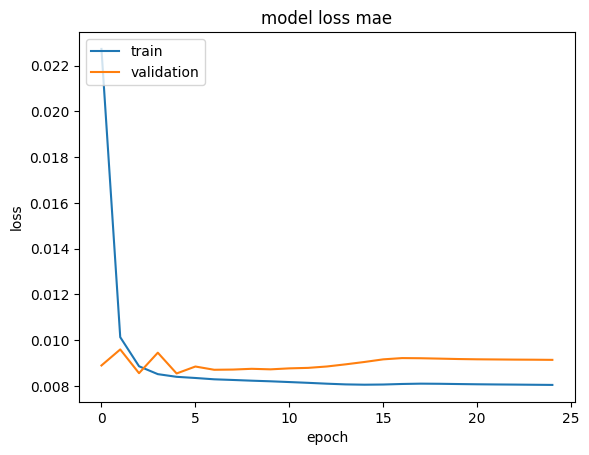

Model: "sequential_58"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_31 (LSTM)              (None, 3, 16)             1216      
                                                                 
 lstm_32 (LSTM)              (None, 16)                2112      
                                                                 
 dense_93 (Dense)            (None, 8)                 136       
                                                                 
 dense_94 (Dense)            (None, 1)                 9         
                                                                 
Total params: 3,473
Trainable params: 3,473
Non-trainable params: 0
_________________________________________________________________
Test MAE: 1.636
Test RMSE: 2.447
Test MAPE: 2.423
Test R2: 0.002


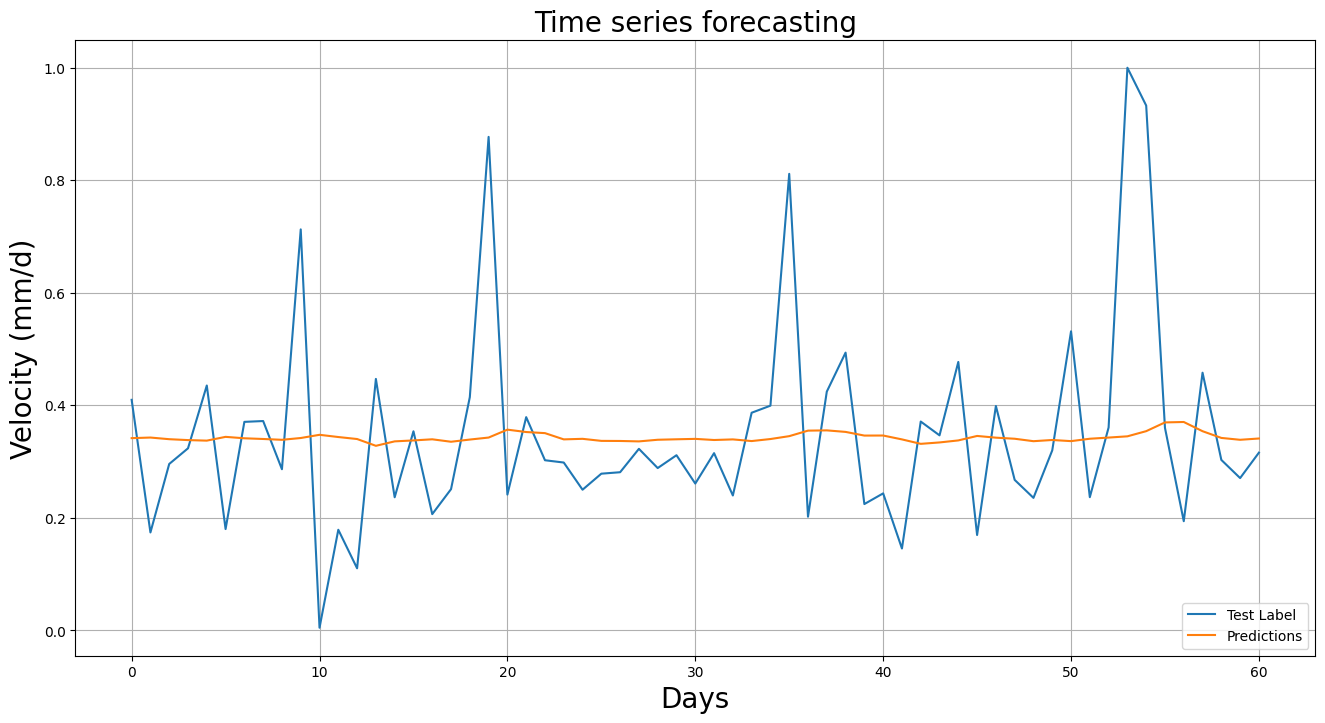

-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
MULTI_LSTM
Filters:  16
Learning rate:  0.01
Batch size:  9
Look back:  5
(156, 12)
(95, 10) 95 (95,)
(95, 5, 2) (95,) (61, 5, 2) (61,)
Model: "sequential_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_33 (LSTM)              (None, 5, 16)             1216      
                                                                 
 lstm_34 (LSTM)              (None, 16)                2112      
                                                                 
 dense_95 (Dense)            (None, 8)                 136       
                                                                 
 dense_96 (Dense)            (None, 1)                 9         
                                                                 
Total par

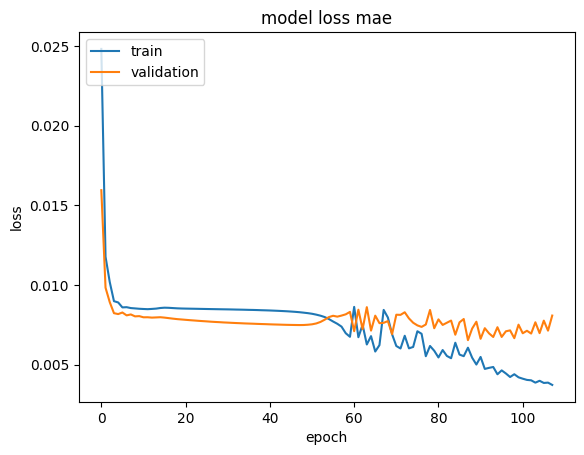

Model: "sequential_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_35 (LSTM)              (None, 5, 16)             1216      
                                                                 
 lstm_36 (LSTM)              (None, 16)                2112      
                                                                 
 dense_97 (Dense)            (None, 8)                 136       
                                                                 
 dense_98 (Dense)            (None, 1)                 9         
                                                                 
Total params: 3,473
Trainable params: 3,473
Non-trainable params: 0
_________________________________________________________________
Test MAE: 2.037
Test RMSE: 3.189
Test MAPE: 4.298
Test R2: -0.696


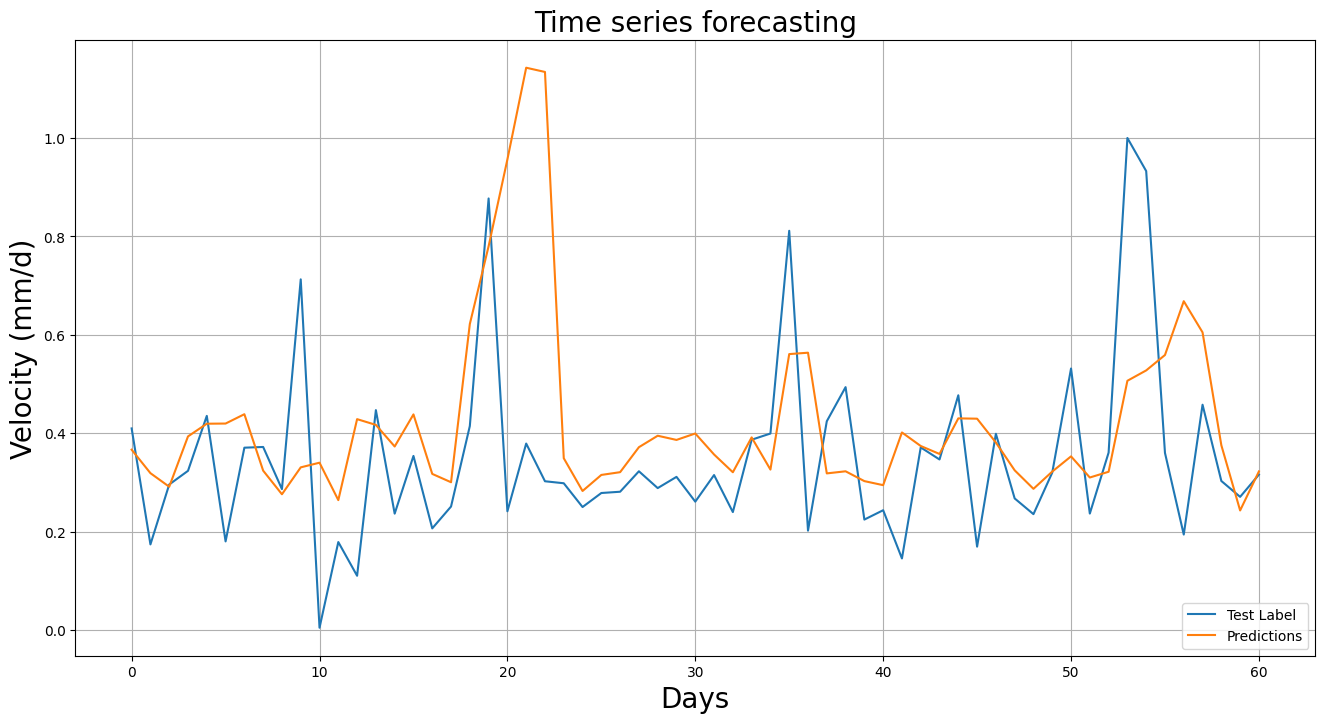

-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
MULTI_LSTM
Filters:  16
Learning rate:  0.01
Batch size:  9
Look back:  7
(154, 16)
(93, 14) 93 (93,)
(93, 7, 2) (93,) (61, 7, 2) (61,)
Model: "sequential_61"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_37 (LSTM)              (None, 7, 16)             1216      
                                                                 
 lstm_38 (LSTM)              (None, 16)                2112      
                                                                 
 dense_99 (Dense)            (None, 8)                 136       
                                                                 
 dense_100 (Dense)           (None, 1)                 9         
                                                                 
Total par

KeyboardInterrupt: 

In [16]:
### MULTI_LSTM ###


dic = {}

# number of filters/nodes
filters = [16, 32, 64, 96, 128, 256]
# learning rates
lr = [10e-3, 5e-3, 10e-4, 5e-4, 10e-5, 5e-5]
# epochs
epochs = 1000
# batch sizes
batch_size = [9, 18, 36, 72, 144]
# how many time steps back do we want the model to see
look_backs = [3, 5, 7, 9, 12]

# Hyperparameters
dic["batch_size"] = []
dic["learning_rate"] = []
dic["filters"] = []
dic["look_backs"] = []

# test_scores
dic["MAE"] = []
dic["RMSE"] = []
dic["MAPE"] = []
dic["R2"] = []

for fil in filters:
    for learning_rate in lr:
        for batch in batch_size:
            for look in look_backs:
                print('-------------------------------------------------------------------------------------')
                print('MULTI_LSTM')
                print('Filters: ', fil)
                print('Learning rate: ',learning_rate)
                print('Batch size: ',batch)
                print('Look back: ',look)

                # load dataset
                values = dataset.values
                # integer encode direction
                values = values.astype('float32')
                # normalize features
                scaler = MinMaxScaler(feature_range=(0, 1))
                scaled = scaler.fit_transform(values)
                # specify the number of lag hours
                n_hours = look
                # frame as supervised learning
                reframed = series_to_supervised(scaled, n_hours, 1)
                print(reframed.shape)

                # split into train and test sets
                values = reframed.values
                n_train_hours = hours_train - look
                train = values[:n_train_hours, :]
                test = values[n_train_hours:, :]
                # split into input and outputs
                n_obs = n_hours * n_features
                train_X, train_y = train[:, :n_obs], train[:, -n_features]
                test_X, test_y = test[:, :n_obs], test[:, -n_features]
                print(train_X.shape, len(train_X), train_y.shape)

                # reshape input to be 3D [samples, timesteps, features]
                train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
                test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
                print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

                n = - n_features + 1


                def multi_LSTM_net(filters, lr):
                    model = Sequential()
                    model.add(LSTM(filters, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
                    model.add(LSTM(filters, return_sequences=False, input_shape=(train_X.shape[1], train_X.shape[2])))
                    model.add(Dense(filters / 2))
                    model.add(Dense(1))
                    model.compile(loss=tf.losses.Huber(),
                                  optimizer=tf.optimizers.Adam(learning_rate=lr),
                                  metrics=[tf.metrics.MeanAbsoluteError(), tf.metrics.MeanSquaredError()])
                    model.summary()
                    return model


                # load the model
                model = multi_LSTM_net(filters=fil, lr=learning_rate)
                # Save the models only when validation loss decrease
                early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',  # what is the metric to measure
                                                              patience=20,
                                                              # how many epochs to continue running the model after seeing an increase in val_loss
                                                              restore_best_weights=True)  # update the model weights
                model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                    f'models/multi_LSTM/weights/filters_{fil}_batch_size_{batch}_lr_{learning_rate}_look_back_{look}.hdf5',
                    monitor='val_loss', mode='min', verbose=0,
                    save_best_only=True, save_weights_only=True)
                # fit network
                history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch, validation_split=0.2, verbose=0,
                                    shuffle=False, callbacks=[model_checkpoint, early_stop])

                plt.plot(history.history['loss'])
                plt.plot(history.history['val_loss'])
                plt.title('model loss mae')
                plt.ylabel('loss')
                plt.xlabel('epoch')
                plt.legend(['train', 'validation'], loc='upper left')
                # save plots
                plt.savefig(f"models/multi_LSTM/plots/filters_{fil}_batch_size_{batch}_lr_{learning_rate}_look_back_{look}.png")
                plt.show()

                # load model to evaluate the test data
                multi_LSTM_model = multi_LSTM_net(filters=fil, lr=learning_rate)
                # load the last saved weight from the training
                multi_LSTM_model.load_weights(
                    f"models/multi_LSTM/weights/filters_{fil}_batch_size_{batch}_lr_{learning_rate}_look_back_{look}.hdf5")

                # Evaluate the model
                yhat = multi_LSTM_model.predict(test_X)
                test_X_res = test_X.reshape((test_X.shape[0], n_hours * n_features))
                # invert scaling for forecast
                inv_yhat = concatenate((yhat, test_X_res[:, n:]), axis=1)
                inv_yhat = scaler.inverse_transform(inv_yhat)
                inv_yhat = inv_yhat[:, 0]
                # invert scaling for actual
                test_y = test_y.reshape((len(test_y), 1))
                inv_y = concatenate((test_y, test_X_res[:, n:]), axis=1)
                inv_y = scaler.inverse_transform(inv_y)
                inv_y = inv_y[:, 0]

                # calculate MAE
                mae = mean_absolute_error(inv_y, inv_yhat)
                print('Test MAE: %.3f' % mae)
                # calculate RMSE
                rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
                print('Test RMSE: %.3f' % rmse)
                # calculate MAPE
                mape = mean_absolute_percentage_error(inv_y, inv_yhat)
                print('Test MAPE: %.3f' % mape)
                # calculate R2
                r2 = r2_score(inv_y, inv_yhat)
                print('Test R2: %.3f' % r2)

                # plot and save preds
                plt.figure(figsize=(16, 8))
                plt.title('Time series forecasting', size=20)
                # plt.ylim([0,1.3])
                plt.plot(pd.DataFrame(test_y), label='Test Label')
                plt.plot(pd.DataFrame(yhat), label='Predictions')
                plt.legend(loc='lower right', markerscale=1)
                plt.xlabel('Days', size=20)
                plt.ylabel('Velocity (mm/d)', size=20)
                plt.grid(True)
                plt.savefig(f"models/multi_LSTM/preds/filters_{fil}_batch_size_{batch}_lr_{learning_rate}_look_back_{look}.png",
                            facecolor='white', edgecolor='none', bbox_inches='tight')
                plt.show()

                # save results on the dictionary
                dic["batch_size"].append(batch)
                dic["learning_rate"].append(learning_rate)
                dic["filters"].append(fil)
                dic["look_backs"].append(look)
                dic["MAE"].append(mae)
                dic["RMSE"].append(rmse)
                dic["MAPE"].append(mape)
                dic["R2"].append(r2)

                # Convert results to a dataframe
                results = pd.DataFrame(dic)
                # Export as csv
                results.to_csv(f'models/multi_LSTM/results/multi_LSTM_results.csv', index=False)
                print('-------------------------------------------------------------------------------------')

print('multi_LSTM finished!')

-------------------------------------------------------------------------------------
MULTI_BI_LSTM
Filters:  16
Learning rate:  0.01
Batch size:  9
Look back:  3
(158, 8)
(97, 6) 97 (97,)
(97, 3, 2) (97,) (61, 3, 2) (61,)
Model: "sequential_62"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 3, 32)            2432      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               6272      
 nal)                                                            
                                                                 
 dense_101 (Dense)           (None, 8)                 264       
                                                                 
 dense_102 (Dense)           (None, 1)                 9         
                            

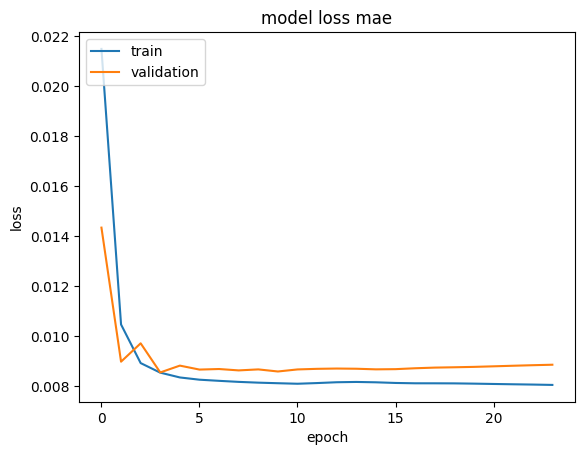

Model: "sequential_63"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirectio  (None, 3, 32)            2432      
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 32)               6272      
 nal)                                                            
                                                                 
 dense_103 (Dense)           (None, 8)                 264       
                                                                 
 dense_104 (Dense)           (None, 1)                 9         
                                                                 
Total params: 8,977
Trainable params: 8,977
Non-trainable params: 0
_________________________________________________________________
Test MAE: 1.622
Test RMSE: 2.413
Test MAPE: 2.423
T

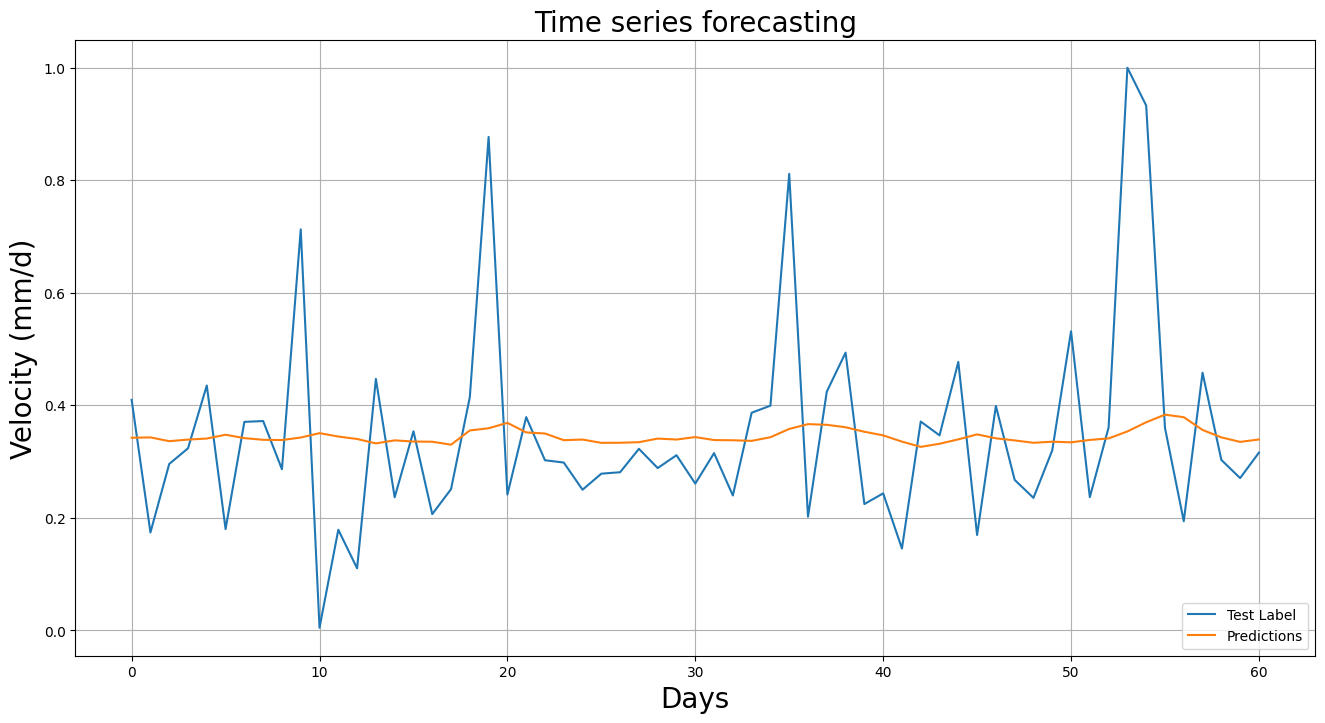

-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
MULTI_BI_LSTM
Filters:  16
Learning rate:  0.01
Batch size:  9
Look back:  5
(156, 12)
(95, 10) 95 (95,)
(95, 5, 2) (95,) (61, 5, 2) (61,)
Model: "sequential_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_4 (Bidirectio  (None, 5, 32)            2432      
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 32)               6272      
 nal)                                                            
                                                                 
 dense_105 (Dense)           (None, 8)                 264       
                                                                 
 dense

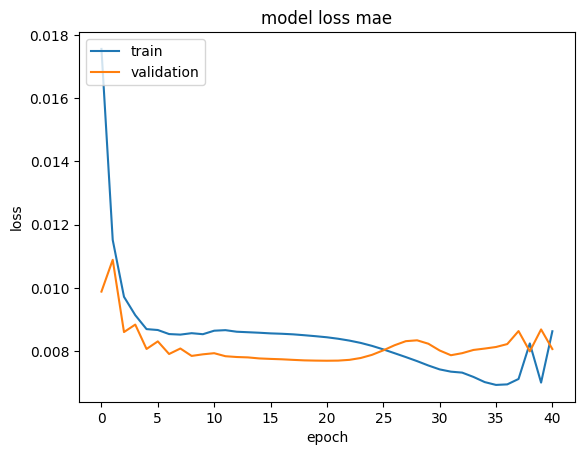

Model: "sequential_65"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_6 (Bidirectio  (None, 5, 32)            2432      
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 32)               6272      
 nal)                                                            
                                                                 
 dense_107 (Dense)           (None, 8)                 264       
                                                                 
 dense_108 (Dense)           (None, 1)                 9         
                                                                 
Total params: 8,977
Trainable params: 8,977
Non-trainable params: 0
_________________________________________________________________
Test MAE: 1.492
Test RMSE: 2.300
Test MAPE: 2.125
T

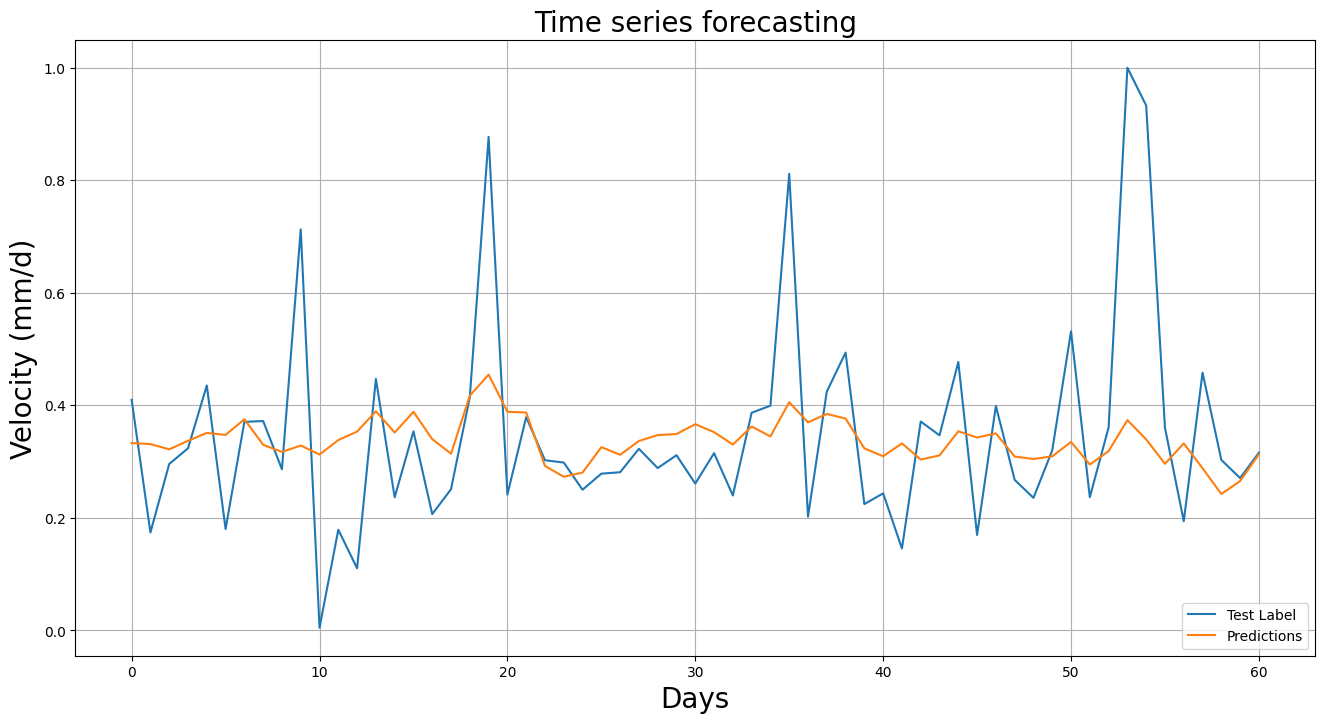

-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
MULTI_BI_LSTM
Filters:  16
Learning rate:  0.01
Batch size:  9
Look back:  7
(154, 16)
(93, 14) 93 (93,)
(93, 7, 2) (93,) (61, 7, 2) (61,)
Model: "sequential_66"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_8 (Bidirectio  (None, 7, 32)            2432      
 nal)                                                            
                                                                 
 bidirectional_9 (Bidirectio  (None, 32)               6272      
 nal)                                                            
                                                                 
 dense_109 (Dense)           (None, 8)                 264       
                                                                 
 dense

KeyboardInterrupt: 

In [17]:
### MULTI_BI_LSTM ###


dic = {}

# number of filters/nodes
filters = [16, 32, 64, 96, 128, 256]
# learning rates
lr = [10e-3, 5e-3, 10e-4, 5e-4, 10e-5, 5e-5]
# epochs
epochs = 1000
# batch sizes
batch_size = [9, 18, 36, 72, 144]
# how many time steps back do we want the model to see
look_backs = [3, 5, 7, 9, 12]

# Hyperparameters
dic["batch_size"] = []
dic["learning_rate"] = []
dic["filters"] = []
dic["look_backs"] = []

# test_scores
dic["MAE"] = []
dic["RMSE"] = []
dic["MAPE"] = []
dic["R2"] = []

for fil in filters:
    for learning_rate in lr:
        for batch in batch_size:
            for look in look_backs:
                print('-------------------------------------------------------------------------------------')
                print('MULTI_BI_LSTM')
                print('Filters: ', fil)
                print('Learning rate: ', learning_rate)
                print('Batch size: ', batch)
                print('Look back: ', look)
                # load dataset
                values = dataset.values
                # ensure all data is float
                values = values.astype('float32')
                # normalize features
                scaler = MinMaxScaler(feature_range=(0, 1))
                scaled = scaler.fit_transform(values)
                # specify the number of lag hours
                n_hours = look
                # frame as supervised learning
                reframed = series_to_supervised(scaled, n_hours, 1)
                print(reframed.shape)

                # split into train and test sets
                values = reframed.values
                n_train_hours = hours_train - look
                train = values[:n_train_hours, :]
                test = values[n_train_hours:, :]
                # split into input and outputs
                n_obs = n_hours * n_features
                train_X, train_y = train[:, :n_obs], train[:, -n_features]
                test_X, test_y = test[:, :n_obs], test[:, -n_features]
                print(train_X.shape, len(train_X), train_y.shape)

                # reshape input to be 3D [samples, timesteps, features]
                train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
                test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
                print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

                n = - n_features + 1


                def multi_bi_LSTM_net(filters, lr):
                    model = Sequential()
                    model.add(Bidirectional(LSTM(filters, return_sequences=True),
                                            input_shape=(train_X.shape[1], train_X.shape[2])))
                    model.add(Bidirectional(LSTM(filters, return_sequences=False),
                                            input_shape=(train_X.shape[1], train_X.shape[2])))
                    model.add(Dense(filters / 2))
                    model.add(Dense(units=1))
                    model.compile(loss=tf.losses.Huber(),
                                  optimizer=tf.optimizers.Adam(learning_rate=lr),
                                  metrics=[tf.metrics.MeanAbsoluteError(), tf.metrics.MeanSquaredError()])
                    model.summary()
                    return model


                # load the model
                model = multi_bi_LSTM_net(filters=fil, lr=learning_rate)
                # Save the models only when validation loss decrease
                early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',  # what is the metric to measure
                                                              patience=20,
                                                              # how many epochs to continue running the model after seeing an increase in val_loss
                                                              restore_best_weights=True)  # update the model weights
                model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                    f'models/multi_bi_LSTM/weights/filters_{fil}_batch_size_{batch}_lr_{learning_rate}_look_back_{look}.hdf5',
                    monitor='val_loss', mode='min', verbose=0,
                    save_best_only=True, save_weights_only=True)
                # fit network
                history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch, validation_split=0.2, verbose=0,
                                    shuffle=False, callbacks=[model_checkpoint, early_stop])

                plt.plot(history.history['loss'])
                plt.plot(history.history['val_loss'])
                plt.title('model loss mae')
                plt.ylabel('loss')
                plt.xlabel('epoch')
                plt.legend(['train', 'validation'], loc='upper left')
                # save plots
                plt.savefig(f"models/multi_bi_LSTM/plots/filters_{fil}_batch_size_{batch}_lr_{learning_rate}_look_back_{look}.png")
                plt.show()

                # load model to evaluate the test data
                multi_bi_LSTM_model = multi_bi_LSTM_net(filters=fil, lr=learning_rate)
                # load the last saved weight from the training
                multi_bi_LSTM_model.load_weights(
                    f"models/multi_bi_LSTM/weights/filters_{fil}_batch_size_{batch}_lr_{learning_rate}_look_back_{look}.hdf5")

                # Evaluate the model
                yhat = multi_bi_LSTM_model.predict(test_X)
                test_X_res = test_X.reshape((test_X.shape[0], n_hours * n_features))
                # invert scaling for forecast
                inv_yhat = concatenate((yhat, test_X_res[:, n:]), axis=1)
                inv_yhat = scaler.inverse_transform(inv_yhat)
                inv_yhat = inv_yhat[:, 0]
                # invert scaling for actual
                test_y = test_y.reshape((len(test_y), 1))
                inv_y = concatenate((test_y, test_X_res[:, n:]), axis=1)
                inv_y = scaler.inverse_transform(inv_y)
                inv_y = inv_y[:, 0]

                # calculate MAE
                mae = mean_absolute_error(inv_y, inv_yhat)
                print('Test MAE: %.3f' % mae)
                # calculate RMSE
                rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
                print('Test RMSE: %.3f' % rmse)
                # calculate MAPE
                mape = mean_absolute_percentage_error(inv_y, inv_yhat)
                print('Test MAPE: %.3f' % mape)
                # calculate R2
                r2 = r2_score(inv_y, inv_yhat)
                print('Test R2: %.3f' % r2)

                # plot and save preds
                plt.figure(figsize=(16, 8))
                plt.title('Time series forecasting', size=20)
                # plt.ylim([0,1.3])
                plt.plot(pd.DataFrame(test_y), label='Test Label')
                plt.plot(pd.DataFrame(yhat), label='Predictions')
                plt.legend(loc='lower right', markerscale=1)
                plt.xlabel('Days', size=20)
                plt.ylabel('Velocity (mm/d)', size=20)
                plt.grid(True)
                plt.savefig(f"models/multi_bi_LSTM/preds/filters_{fil}_batch_size_{batch}_lr_{learning_rate}_look_back_{look}.png",
                            facecolor='white', edgecolor='none', bbox_inches='tight')
                plt.show()

                # save results on the dictionary
                dic["batch_size"].append(batch)
                dic["learning_rate"].append(learning_rate)
                dic["filters"].append(fil)
                dic["look_backs"].append(look)
                dic["MAE"].append(mae)
                dic["RMSE"].append(rmse)
                dic["MAPE"].append(mape)
                dic["R2"].append(r2)

                # Convert results to a dataframe
                results = pd.DataFrame(dic)
                # Export as csv
                results.to_csv(f'models/multi_bi_LSTM/results/multi_bi_LSTM_results.csv', index=False)
                print('-------------------------------------------------------------------------------------')

print('multi_Bi_LSTM finished!')

-------------------------------------------------------------------------------------
CONV
Filters:  16
Learning rate:  0.01
Batch size:  9
Look back:  3
(158, 8)
(97, 6) 97 (97,)
(97, 3, 2) (97,) (61, 3, 2) (61,)
Model: "sequential_70"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 3, 16)             112       
                                                                 
 dense_117 (Dense)           (None, 3, 16)             272       
                                                                 
 dense_118 (Dense)           (None, 3, 1)              17        
                                                                 
Total params: 401
Trainable params: 401
Non-trainable params: 0
_________________________________________________________________


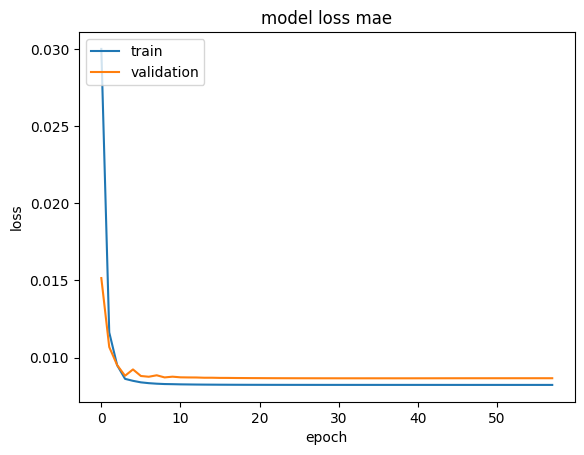

Model: "sequential_71"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 3, 16)             112       
                                                                 
 dense_119 (Dense)           (None, 3, 16)             272       
                                                                 
 dense_120 (Dense)           (None, 3, 1)              17        
                                                                 
Total params: 401
Trainable params: 401
Non-trainable params: 0
_________________________________________________________________
Test MAE: 1.617
Test RMSE: 2.494
Test MAPE: 1.819
Test R2: -0.037


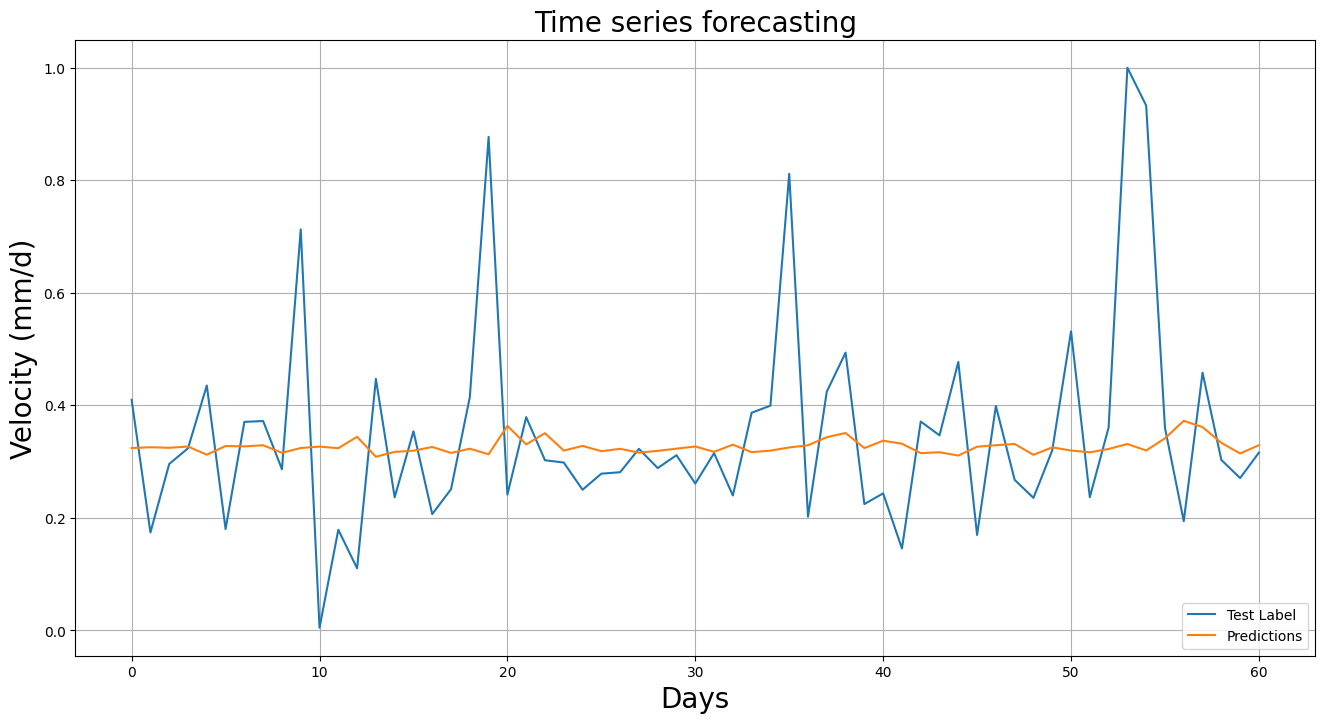

-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
CONV
Filters:  16
Learning rate:  0.01
Batch size:  9
Look back:  5
(156, 12)
(95, 10) 95 (95,)
(95, 5, 2) (95,) (61, 5, 2) (61,)
Model: "sequential_72"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 5, 16)             176       
                                                                 
 dense_121 (Dense)           (None, 5, 16)             272       
                                                                 
 dense_122 (Dense)           (None, 5, 1)              17        
                                                                 
Total params: 465
Trainable params: 465
Non-trainable params: 0
_________________________________________________________________


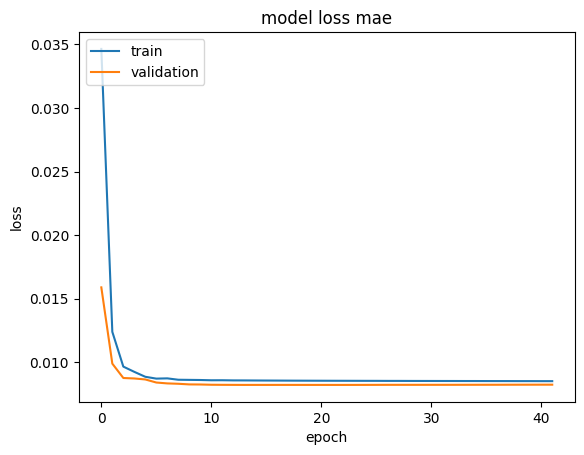

Model: "sequential_73"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 5, 16)             176       
                                                                 
 dense_123 (Dense)           (None, 5, 16)             272       
                                                                 
 dense_124 (Dense)           (None, 5, 1)              17        
                                                                 
Total params: 465
Trainable params: 465
Non-trainable params: 0
_________________________________________________________________
Test MAE: 1.677
Test RMSE: 2.506
Test MAPE: 2.307
Test R2: -0.047


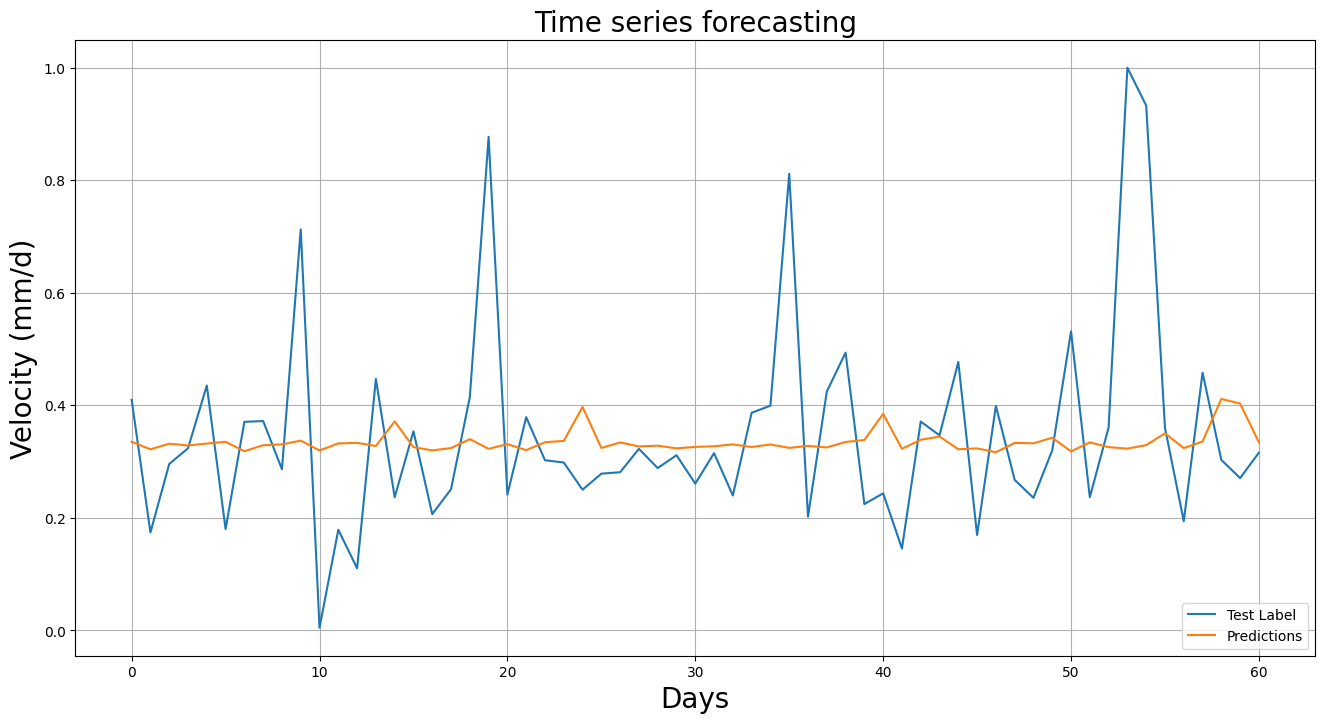

-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
CONV
Filters:  16
Learning rate:  0.01
Batch size:  9
Look back:  7
(154, 16)
(93, 14) 93 (93,)
(93, 7, 2) (93,) (61, 7, 2) (61,)
Model: "sequential_74"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_7 (Conv1D)           (None, 7, 16)             240       
                                                                 
 dense_125 (Dense)           (None, 7, 16)             272       
                                                                 
 dense_126 (Dense)           (None, 7, 1)              17        
                                                                 
Total params: 529
Trainable params: 529
Non-trainable params: 0
_________________________________________________________________


KeyboardInterrupt: 

In [19]:
### CONV ###


dic = {}

# number of filters/nodes
filters = [16, 32, 64, 96, 128, 256]
# learning rates
lr = [10e-3, 5e-3, 10e-4, 5e-4, 10e-5, 5e-5]
# epochs
epochs = 1000
# batch sizes
batch_size = [9, 18, 36, 72, 144]
# how many time steps back do we want the model to see
look_backs = [3, 5, 7, 9, 12]

# if you want, you can tune the conv kernel size as well here. To simplify (and speed up), the kernel size is set == to the look back

# Hyperparameters
dic["batch_size"] = []
dic["learning_rate"] = []
dic["filters"] = []
dic["k_size"] = []
dic["look_backs"] = []


# test_scores
dic["MAE"] = []
dic["RMSE"] = []
dic["MAPE"] = []
dic["R2"] = []

for fil in filters:
    for learning_rate in lr:
        for batch in batch_size:
            for look in look_backs:
                print('-------------------------------------------------------------------------------------')
                print('CONV')
                print('Filters: ', fil)
                print('Learning rate: ', learning_rate)
                print('Batch size: ', batch)
                print('Look back: ', look)
                                # load dataset
                values = dataset.values
                # ensure all data is float
                values = values.astype('float32')
                # normalize features
                scaler = MinMaxScaler(feature_range=(0, 1))
                scaled = scaler.fit_transform(values)
                # specify the number of lag hours
                n_hours = look
                # frame as supervised learning
                reframed = series_to_supervised(scaled, n_hours, 1)
                print(reframed.shape)

                # split into train and test sets
                values = reframed.values
                n_train_hours = hours_train-look
                train = values[:n_train_hours, :]
                test = values[n_train_hours:, :]
                # split into input and outputs
                n_obs = n_hours * n_features
                train_X, train_y = train[:, :n_obs], train[:, -n_features]
                test_X, test_y = test[:, :n_obs], test[:, -n_features]
                print(train_X.shape, len(train_X), train_y.shape)

                # reshape input to be 3D [samples, timesteps, features]
                train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
                test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
                print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

                n = - n_features + 1

                k_size = [look]

                def conv_net(filters, lr):
                    # design network
                    model = Sequential()
                    model.add(Conv1D(filters=filters, kernel_size=k_size,
                                                   strides=1, padding="causal",
                                                   activation="relu",
                                                   input_shape=(train_X.shape[1], train_X.shape[2])))
                    model.add(Dense(units=(filters), activation='relu'))
                    model.add(Dense(units=1))

                    model.compile(loss=tf.losses.Huber(),
                    optimizer=tf.optimizers.Adam(learning_rate=lr),
                    metrics=[tf.metrics.MeanAbsoluteError(), tf.metrics.MeanSquaredError()])
                    model.summary()
                    return model

                 # load the model
                model = conv_net(filters=fil, lr=learning_rate)
                # Save the models only when validation loss decrease
                early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', # what is the metric to measure
                                  patience = 20, # how many epochs to continue running the model after seeing an increase in val_loss
                                  restore_best_weights = True) # update the model weights
                model_checkpoint = tf.keras.callbacks.ModelCheckpoint(f'models/conv/weights/filters_{fil}_kernel_size_{k_size}_batch_size_{batch}_lr_{learning_rate}_look_back_{look}.hdf5',
                                                                      monitor='val_loss', mode='min',verbose=0,
                                                                      save_best_only=True,save_weights_only = True)
                # fit network
                history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch, validation_split=0.2, verbose=0, shuffle=False, callbacks = [model_checkpoint, early_stop])

                plt.plot(history.history['loss'])
                plt.plot(history.history['val_loss'])
                plt.title('model loss mae')
                plt.ylabel('loss')
                plt.xlabel('epoch')
                plt.legend(['train', 'validation'], loc='upper left')
                # save plots
                plt.savefig(f"models/conv/plots/filters_{fil}_kernel_size_{k_size}_batch_size_{batch}_lr_{learning_rate}_look_back_{look}.png")
                plt.show()

                # load model to evaluate the test data
                conv_model = conv_net(filters=fil, lr=learning_rate)
                # load the last saved weight from the training
                conv_model.load_weights(f"models/conv/weights/filters_{fil}_kernel_size_{k_size}_batch_size_{batch}_lr_{learning_rate}_look_back_{look}.hdf5")

               # Evaluate the model
                yhat = conv_model.predict(test_X)
                test_X_res = test_X.reshape((test_X.shape[0], n_hours*n_features))
                # invert scaling for forecast
                inv_yhat = concatenate((yhat[:, 0], test_X_res[:, n:]), axis=1)
                inv_yhat = scaler.inverse_transform(inv_yhat)
                inv_yhat = inv_yhat[:,0]
                # invert scaling for actual
                test_y = test_y.reshape((len(test_y), 1))
                inv_y = concatenate((test_y, test_X_res[:, n:]), axis=1)
                inv_y = scaler.inverse_transform(inv_y)
                inv_y = inv_y[:,0]

                # calculate MAE
                mae = mean_absolute_error(inv_y, inv_yhat)
                print('Test MAE: %.3f' % mae)
                # calculate RMSE
                rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
                print('Test RMSE: %.3f' % rmse)
                # calculate MAPE
                mape = mean_absolute_percentage_error(inv_y, inv_yhat)
                print('Test MAPE: %.3f' % mape)
                # calculate R2
                r2 = r2_score(inv_y, inv_yhat)
                print('Test R2: %.3f' % r2)

                # plot and save preds
                plt.figure(figsize=(16, 8))
                plt.title('Time series forecasting', size=20)
                #plt.ylim([0,1.3])
                plt.plot(pd.DataFrame(test_y), label='Test Label')
                plt.plot(pd.DataFrame(yhat[:,0]), label='Predictions')
                plt.legend(loc='lower right', markerscale=1)
                plt.xlabel('Days', size=20)
                plt.ylabel('Velocity (mm/d)', size=20)
                plt.grid(True)
                plt.savefig(f"models/conv/preds/filters_{fil}_kernel_size_{k_size}_batch_size_{batch}_lr_{learning_rate}_look_back_{look}.png", facecolor='white', edgecolor='none', bbox_inches='tight')
                plt.show()

                # save results on the dictionary
                dic["batch_size"].append(batch)
                dic["learning_rate"].append(learning_rate)
                dic["filters"].append(fil)
                dic["k_size"].append(k_size)
                dic['look_backs'].append(look)
                dic["MAE"].append(mae)
                dic["RMSE"].append(rmse)
                dic["MAPE"].append(mape)
                dic["R2"].append(r2)

                # Convert results to a dataframe
                results = pd.DataFrame(dic)
                # Export as csv
                results.to_csv(f'models/conv/results/conv_results.csv', index = False)
                print('-------------------------------------------------------------------------------------')

print('CONV finished!')

-------------------------------------------------------------------------------------
CONV_LSTM
Filters:  16
Learning rate:  0.01
Batch size:  9
Look back:  3
(158, 8)
(97, 6) 97 (97,)
(97, 3, 2) (97,) (61, 3, 2) (61,)


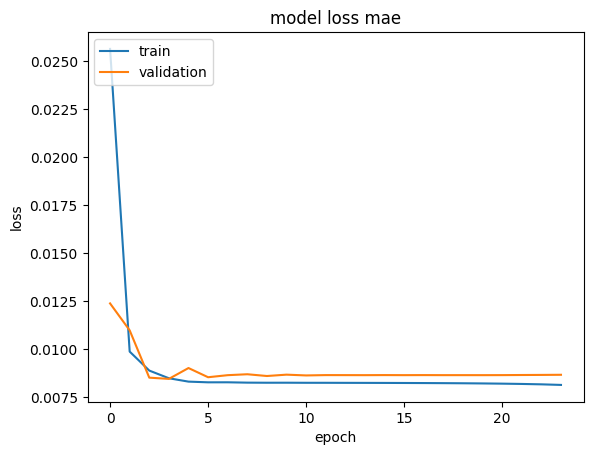

Test MAE: 1.632
Test RMSE: 2.444
Test MAPE: 2.473
Test R2: 0.004


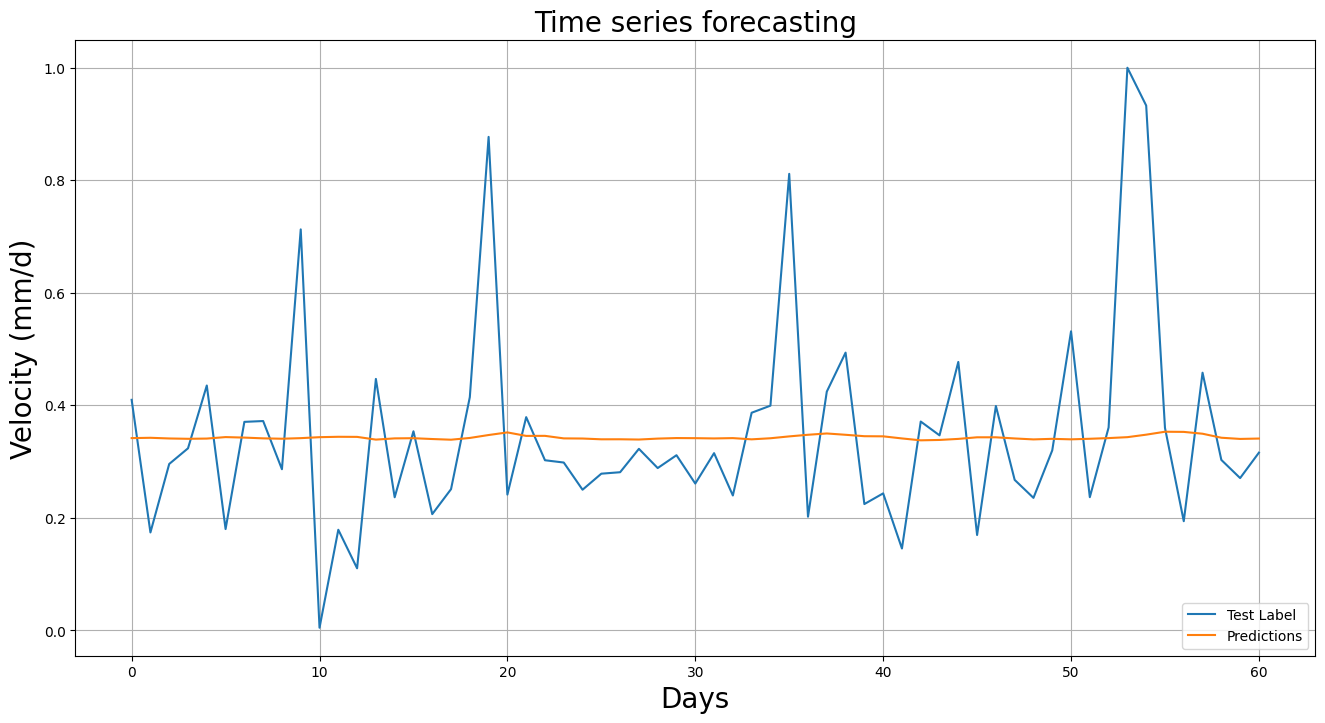

-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
CONV_LSTM
Filters:  16
Learning rate:  0.01
Batch size:  9
Look back:  5
(156, 12)
(95, 10) 95 (95,)
(95, 5, 2) (95,) (61, 5, 2) (61,)


KeyboardInterrupt: 

In [20]:
### CONV_LSTM ###


dic = {}

# number of filters/nodes
filters = [16, 32, 64, 96, 128, 256]
# learning rates
lr = [10e-3, 5e-3, 10e-4, 5e-4, 10e-5, 5e-5]
# epochs
epochs = 1000
# batch sizes
batch_size = [9, 18, 36, 72, 144]
# how many time steps back do we want the model to see
look_backs = [3, 5, 7, 9, 12]

# if you want, you can tune the conv kernel size as well here. To simplify (and speed up), the kernel size is set == to the look back

# Hyperparameters
dic["batch_size"] = []
dic["learning_rate"] = []
dic["filters"] = []
dic["k_size"] = []
dic['look_backs'] = []

# test_scores
dic["MAE"] = []
dic["RMSE"] = []
dic["MAPE"] = []
dic["R2"] = []

for fil in filters:
    for learning_rate in lr:
        for batch in batch_size:
            for look in look_backs:
                print('-------------------------------------------------------------------------------------')
                print('CONV_LSTM')
                print('Filters: ', fil)
                print('Learning rate: ', learning_rate)
                print('Batch size: ', batch)
                print('Look back: ', look)
                values = dataset.values
                # ensure all data is float
                values = values.astype('float32')
                # normalize features
                scaler = MinMaxScaler(feature_range=(0, 1))
                scaled = scaler.fit_transform(values)
                # specify the number of lag hours
                n_hours = look
                # frame as supervised learning
                reframed = series_to_supervised(scaled, n_hours, 1)
                print(reframed.shape)

                # split into train and test sets
                values = reframed.values
                n_train_hours = hours_train - look
                train = values[:n_train_hours, :]
                test = values[n_train_hours:, :]
                # split into input and outputs
                n_obs = n_hours * n_features
                train_X, train_y = train[:, :n_obs], train[:, -n_features]
                test_X, test_y = test[:, :n_obs], test[:, -n_features]
                print(train_X.shape, len(train_X), train_y.shape)

                # reshape input to be 3D [samples, timesteps, features]
                train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
                test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
                print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

                n = - n_features + 1
                # kernel size is set == to the look back
                k_size = [look]


                def conv_LSTM_net(filters, lr):
                    model = Sequential()
                    model.add(Conv1D(filters=filters, kernel_size=k_size,
                                     strides=1, padding="causal",
                                     activation="relu",
                                     input_shape=(train_X.shape[1], train_X.shape[2])))
                    model.add(LSTM(int(filters / 2), return_sequences=True))
                    model.add(LSTM(int(filters / 2), return_sequences=False))
                    model.add(Dense(units=(filters / 4), activation='relu'))
                    model.add(Dense(units=1))

                    model.compile(loss=tf.losses.Huber(),
                                  optimizer=tf.optimizers.Adam(learning_rate=lr),
                                  metrics=[tf.metrics.MeanAbsoluteError(), tf.metrics.MeanSquaredError()])
                    #model.summary()
                    return model


                # load the model
                model = conv_LSTM_net(filters=fil, lr=learning_rate)
                # Save the models only when validation loss decrease
                early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',  # what is the metric to measure
                                                              patience=20,
                                                              # how many epochs to continue running the model after seeing an increase in val_loss
                                                              restore_best_weights=True)  # update the model weights
                model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                    f'models/conv_LSTM/weights/filters_{fil}_kernel_size_{k_size}_batch_size_{batch}_lr_{learning_rate}_look_back_{look}.hdf5',
                    monitor='val_loss', mode='min', verbose=0,
                    save_best_only=True, save_weights_only=True)
                # fit network
                history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch, validation_split=0.2, verbose=0,
                                    shuffle=False, callbacks=[model_checkpoint, early_stop])

                plt.plot(history.history['loss'])
                plt.plot(history.history['val_loss'])
                plt.title('model loss mae')
                plt.ylabel('loss')
                plt.xlabel('epoch')
                plt.legend(['train', 'validation'], loc='upper left')
                # save plots
                plt.savefig(
                    f"models/conv_LSTM/plots/filters_{fil}_kernel_size_{k_size}_batch_size_{batch}_lr_{learning_rate}_look_back_{look}.png")
                plt.show()

                # load model to evaluate the test data
                conv_LSTM_model = conv_LSTM_net(filters=fil, lr=learning_rate)
                # load the last saved weight from the training
                conv_LSTM_model.load_weights(
                    f"models/conv_LSTM/weights/filters_{fil}_kernel_size_{k_size}_batch_size_{batch}_lr_{learning_rate}_look_back_{look}.hdf5")

                # Evaluate the model
                yhat = conv_LSTM_model.predict(test_X)
                test_X_res = test_X.reshape((test_X.shape[0], n_hours * n_features))
                # invert scaling for forecast
                inv_yhat = concatenate((yhat, test_X_res[:, n:]), axis=1)
                inv_yhat = scaler.inverse_transform(inv_yhat)
                inv_yhat = inv_yhat[:, 0]
                # invert scaling for actual
                test_y = test_y.reshape((len(test_y), 1))
                inv_y = concatenate((test_y, test_X_res[:, n:]), axis=1)
                inv_y = scaler.inverse_transform(inv_y)
                inv_y = inv_y[:, 0]

                # calculate MAE
                mae = mean_absolute_error(inv_y, inv_yhat)
                print('Test MAE: %.3f' % mae)
                # calculate RMSE
                rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
                print('Test RMSE: %.3f' % rmse)
                # calculate MAPE
                mape = mean_absolute_percentage_error(inv_y, inv_yhat)
                print('Test MAPE: %.3f' % mape)
                # calculate R2
                r2 = r2_score(inv_y, inv_yhat)
                print('Test R2: %.3f' % r2)

                plt.figure(figsize=(16, 8))
                plt.title('Time series forecasting', size=20)
                # plt.ylim([0,1.3])
                plt.plot(pd.DataFrame(test_y), label='Test Label')
                plt.plot(pd.DataFrame(yhat), label='Predictions')
                plt.legend(loc='lower right', markerscale=1)
                plt.xlabel('Days', size=20)
                plt.ylabel('Velocity (mm/d)', size=20)
                plt.grid(True)
                plt.savefig(
                    f"models/conv_LSTM/preds/filters_{fil}_kernel_size_{k_size}_batch_size_{batch}_lr_{learning_rate}_look_back_{look}.png",
                    facecolor='white', edgecolor='none', bbox_inches='tight')
                plt.show()

                # save results on the dictionary
                dic["batch_size"].append(batch)
                dic["learning_rate"].append(learning_rate)
                dic["filters"].append(fil)
                dic["k_size"].append(k_size)
                dic['look_backs'].append(look)
                dic["MAE"].append(mae)
                dic["RMSE"].append(rmse)
                dic["MAPE"].append(mape)
                dic["R2"].append(r2)

                # Convert results to a dataframe
                results = pd.DataFrame(dic)
                # Export as csv
                results.to_csv(f'models/conv_LSTM/results/conv_LSTM_results.csv', index=False)
                print('-------------------------------------------------------------------------------------')

print('CONV_LSTM finished!')